# price回归模型

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import re
import random
import seaborn as sns
from scipy.stats.mstats import winsorize
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from scipy.stats.mstats import winsorize
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 设置中文显示
plt.rcParams["font.family"] = ["SimHei",]
plt.rcParams["axes.unicode_minus"] = False

In [2]:
# 加载数据
train_price = pd.read_csv('ruc_Class25Q2_train_price.csv', low_memory=False)  # 销售训练集 防止 Pandas 分块读取大型 CSV 导致数据类型推断不准确
test_price = pd.read_csv('ruc_Class25Q2_test_price.csv', low_memory=False)    # 销售测试集

## step1 数据处理+特征工程part1

In [3]:
# ===================== 定义通用转换函数 =====================
def chinese_to_number(s):
    chinese_num = {'零':0,'一':1,'二':2,'三':3,'四':4,'五':5,'六':6,'七':7,'八':8,'九':9,
                   '十':10,'百':100,'千':1000,'万':10000,'两':2}
    if pd.isna(s) or str(s).strip() == '':
        return 0
    s = str(s).strip()
    for c in s:
        if c not in chinese_num:
            return 0
    num = 0  # 最终结果
    current = 0  # 当前位数字（个位/十位）
    # 正向遍历解析（更适配“十”的逻辑）
    for c in s:
        val = chinese_num[c]
        if val >= 10000:  # 万
            num = (num + current) * val
            current = 0
        elif val >= 1000:  # 千
            num = (num + current) * val
            current = 0
        elif val >= 100:  # 百
            num = (num + current) * val
            current = 0
        elif val >= 10:  # 十（核心修复逻辑）
            # 处理“十=10、十一=11、二十=20、一百二十=120”
            if current == 0:  # 十开头（十一/十二）
                current = 1 * val  # 十=10
            else: 
                current = current * val
        else:  
            current += val
    num += current
    return num if num != 0 else 0

def convert_area(s):
    """提取面积数值（建筑面积/套内面积）"""
    if pd.isna(s): return None
    match = re.search(r'(\d+\.?\d*)', str(s).strip())
    return float(match.group(1)) if match else None

def convert_ladder_household(s):
    """梯户比例转换（中文转数值后计算比值）"""
    if pd.isna(s): return None
    match = re.match(r'(.+)梯(.+)户', str(s).strip())
    if not match: return None
    ladder = chinese_to_number(match.group(1))
    household = chinese_to_number(match.group(2))
    return ladder/household if (ladder and household and household !=0) else None

def convert_house_age(s):
    """房屋年限转数值"""
    mapping = {'未满两年':1, '满两年':2, '满五年':5}
    return mapping.get(str(s).strip(), None) if not pd.isna(s) else None

def convert_build_year(s):
    """提取建筑年代年份（多年份取均值，缺失/无效返回None）"""
    if pd.isna(s):
        return None
    s = str(s).strip()
    # 提取所有4位数字年份
    match = re.findall(r'(\d{4})', s)
    if not match:
        return None
    # 过滤有效年份（1900-2025年，排除异常值）
    valid_years = []
    for year in match:
        try:
            year_int = int(year)
            if 1900 <= year_int <= 2025:  # 合理建筑年份范围
                valid_years.append(year_int)
        except:
            continue
    # 多年份取均值，无有效年份返回None
    return float(np.mean(valid_years)) if valid_years else None

def convert_house_total(s):
    """提取房屋/楼栋总数"""
    if pd.isna(s): return None
    match = re.search(r'(\d+)', str(s).strip())
    return float(match.group(1)) if match else None

def convert_green_rate(s):
    """绿化率转小数（过滤0-1外的异常值，缺失/无效返回None）"""
    if pd.isna(s):
        return None
    s = str(s).strip()
    match = re.search(r'(\d+\.?\d*)%', s)
    if not match:
        return None
    # 转换并过滤异常值（绿化率转小数后需在0~1之间）
    try:
        rate = float(match.group(1)) / 100
        # 只保留0~1的合理值，异常值返回None
        return rate if 0 <= rate <= 1 else None
    except (ValueError, TypeError):
        return None

def convert_fee(s):
    """费用类转换（单值/范围取平均）"""
    if pd.isna(s): return None
    nums = re.findall(r'(\d+\.?\d*)', str(s).strip())
    if len(nums) == 1: return float(nums[0])
    elif len(nums)>=2: return (float(nums[0])+float(nums[1]))/2
    return None

def convert_parking_fee(s):
    """停车费转换（多值取平均）"""
    if pd.isna(s): return None
    nums = re.findall(r'(\d+\.?\d*)', str(s).strip())
    return sum(float(num) for num in nums)/len(nums) if nums else None

def parse_house_type_sum(type_str):
    """
    解析房屋户型，返回室+厅+厨+卫的数字总和
    :param type_str: 户型文本（如"3室2厅1厨1卫"、"2室1厅"）
    :return: 户型数字总和（int）
    """
    # 空值/非字符串 → 总和为0
    if pd.isna(type_str):
        return 0
    type_str = str(type_str).strip()
    
    # 正则匹配：分别提取室/厅/厨/卫前面的数字（匹配不到则为0）
    room = int(re.search(r'(\d+)室', type_str).group(1)) if re.search(r'(\d+)室', type_str) else 0
    hall = int(re.search(r'(\d+)厅', type_str).group(1)) if re.search(r'(\d+)厅', type_str) else 0
    kitchen = int(re.search(r'(\d+)厨', type_str).group(1)) if re.search(r'(\d+)厨', type_str) else 0
    bathroom = int(re.search(r'(\d+)卫', type_str).group(1)) if re.search(r'(\d+)卫', type_str) else 0
    
    # 返回总和
    return room + hall + kitchen + bathroom

def process_floor(floor_str):
    """所在楼层分类"""
    if pd.isna(floor_str): return '其他'
    floor_str = str(floor_str).lower()
    if '地' in floor_str: return '地'
    elif '低' in floor_str: return '低'
    elif '底' in floor_str: return '底'
    elif '顶' in floor_str: return '顶'
    elif '高' in floor_str: return '高'
    elif '中' in floor_str: return '中'
    else: return '其他'

def process_orientation(orient_str):
    """房屋朝向：是否含南"""
    return 1 if (not pd.isna(orient_str) and '南' in str(orient_str)) else 0

def process_transaction_rights(right_str):
    """交易权属分级"""
    if pd.isna(right_str): return 0
    s = str(right_str)
    if '商品房' in s: return 4
    elif s in ['私产','房改房','已购公房','售后公房','限价商品房']: return 3
    elif '一类经济适用房' in s: return 2
    elif s in ['二类经济适用房','拆迁还建房','定向安置房','动迁安置房','回迁房']: return 1
    else: return 0

def process_house_use(use_str):
    """房屋用途分级"""
    if pd.isna(use_str):
        return 0
    s = str(use_str).strip()
    if '别墅' in s:
        return 3  # 别墅房价最高，单独分级
    elif '普通住宅' in s:
        return 2
    elif '车库' in s or '车位' in s:
        return -1
    elif '商业' in s or '办公' in s:
        return 1
    else:
        return 0
        
def process_property_type(type_str):
    """物业类别：是否含别墅"""
    return 1 if (not pd.isna(type_str) and '别墅' in str(type_str)) else 0

def process_structure(struct_str):
    """建筑结构分级"""
    if pd.isna(struct_str): return 0
    s = str(struct_str)
    if '平房' in s: return 3
    elif '板楼' in s: return 2
    elif '塔板结合' in s: return 1
    else: return 0

def process_property_desc(desc_str):
    """产权描述：是否含商品房"""
    return 1 if (not pd.isna(desc_str) and '商品房' in str(desc_str)) else 0

def calculate_text_score(text, keywords, is_feedback=False):
    """通用文本得分计算（正向/负向）"""
    if pd.isna(text): return 0.0
    text = str(text).lower()
    if is_feedback:
        pos_kw, neg_kw = keywords
        score = sum(1 for kw in pos_kw if kw in text) - sum(1 for kw in neg_kw if kw in text)
    else:
        score = sum(1 for kw in keywords if kw in text)
    return score

def add_tfidf_features_train(df):
    """给核心卖点/户型介绍加TF-IDF特征（十万行数据适配）"""
    # 停用词：过滤无意义中文词，避免占维度
    stop_words = ['的', '了', '是', '有', '无', '好', '很', '都', '也', '还', '就', '在', '无描述', '业主诚心出售'
                 , '看房方便', '宽阔', '开阔' , '房', '充足']
    tfidf_models = {}
    # ========== 核心卖点（十万行数据，max_features=15，更精准） ==========
    if '核心卖点' in df.columns:
        core_sell_series = df['核心卖点'].fillna('无卖点')
        tfidf_core = TfidfVectorizer(
            token_pattern=r'[\u4e00-\u9fa5]+',
            max_features=15,
            stop_words=stop_words,
            lowercase=False,
            smooth_idf=True
        )
        # 训练集：fit+transform
        tfidf_core_mat = tfidf_core.fit_transform(core_sell_series)
        tfidf_core_df = pd.DataFrame(
            tfidf_core_mat.toarray(),
            columns=[f'核心卖点_tfidf_{kw}' for kw in tfidf_core.get_feature_names_out()],
            index=df.index
        )
        df = pd.concat([df, tfidf_core_df], axis=1)
        # 保存训练好的模型
        tfidf_models['core_sell'] = tfidf_core
    # ========== 户型介绍（训练集fit+transform） ==========
    if '户型介绍' in df.columns:
        house_type_series = df['户型介绍'].fillna('无介绍')
        tfidf_type = TfidfVectorizer(
            token_pattern=r'[\u4e00-\u9fa5]+',
            max_features=5,
            stop_words=stop_words,
            lowercase=False
        )
        tfidf_type_mat = tfidf_type.fit_transform(house_type_series)
        tfidf_type_df = pd.DataFrame(
            tfidf_type_mat.toarray(),
            columns=[f'户型介绍_tfidf_{kw}' for kw in tfidf_type.get_feature_names_out()],
            index=df.index
        )
        df = pd.concat([df, tfidf_type_df], axis=1)
        # 保存训练好的模型
        tfidf_models['house_type'] = tfidf_type
    return df, tfidf_models

def add_tfidf_features_predict(df, tfidf_models):
    """
    验证/测试集专用：仅用训练集的模型transform，保证特征列一致
    """
    # 先复制df避免修改原数据（可选，但建议加）
    df_copy = df.copy()
    # ========== 核心卖点（仅transform） ==========
    if '核心卖点' in df_copy.columns and 'core_sell' in tfidf_models:
        core_sell_series = df_copy['核心卖点'].fillna('无卖点')
        # 用训练集的模型transform（不fit！）
        tfidf_core_mat = tfidf_models['core_sell'].transform(core_sell_series)
        # 列名必须复用训练集的（从模型中提取）
        core_cols = [f'核心卖点_tfidf_{kw}' for kw in tfidf_models['core_sell'].get_feature_names_out()]
        tfidf_core_df = pd.DataFrame(
            tfidf_core_mat.toarray(),
            columns=core_cols,
            index=df_copy.index
        )
        df_copy = pd.concat([df_copy, tfidf_core_df], axis=1)
    # ========== 户型介绍（仅transform） ==========
    if '户型介绍' in df_copy.columns and 'house_type' in tfidf_models:
        house_type_series = df_copy['户型介绍'].fillna('无介绍')
        # 用训练集的模型transform（不fit！）
        tfidf_type_mat = tfidf_models['house_type'].transform(house_type_series)
        # 列名复用训练集的
        type_cols = [f'户型介绍_tfidf_{kw}' for kw in tfidf_models['house_type'].get_feature_names_out()]
        tfidf_type_df = pd.DataFrame(
            tfidf_type_mat.toarray(),
            columns=type_cols,
            index=df_copy.index
        )
        df_copy = pd.concat([df_copy, tfidf_type_df], axis=1)
    
    return df_copy

In [4]:
# ===================== 核心：统一数据处理函数 =====================
def process_data(df, is_train=False, train_stats=None):
    """
    统一处理训练/测试集
    :param df: 待处理数据集
    :param is_train: 是否为训练集（True=训练集，False=测试集）
    :param train_stats: 训练集统计量字典（测试集复用）
    :return: 处理后的数据集 + 训练集统计量（仅训练集返回）
    """
    # 1. 删除冗余列
    df = df.drop(columns=['抵押信息', '别墅类型', '物业办公电话', '环线位置'], errors='ignore')
    
    # 2. 基础特征转换
    converters = {
        '建筑面积': convert_area, '套内面积': convert_area, '梯户比例': convert_ladder_household,
        '房屋年限': convert_house_age, '建筑年代': convert_build_year, '房屋总数': convert_house_total,
        '楼栋总数': convert_house_total, '绿 化 率': convert_green_rate, '物 业 费': convert_fee,
        '燃气费': convert_fee, '供热费': convert_fee, '停车费用': convert_parking_fee
    }
    for col, func in converters.items():
        if col in df.columns:
            df[col] = df[col].apply(func).astype(float)
    
    # 3. 初始化训练集统计量（仅训练集）
    if is_train:
        train_stats = {
            'median_diff': (df['建筑面积'] - df['套内面积']).median() if all(c in df.columns for c in ['建筑面积','套内面积']) else 0,
            'medians': {}, 'modes': {}, 'outlier_thresholds': {},
            'onehot_cols': {'low_cardinal': [], 'floor': [], 'ring': [], 'age': []},
            'train_cols': [],  # 记录训练集最终列名
            'random_fill_vals': {}  # 记录随机填充的非缺失值
        }
        
        # 3.1 训练集删除缺失过多的行（特征转换后执行）
        missing_per_row = df.isnull().sum(axis=1)
        df = df.drop(index=missing_per_row[missing_per_row >=28].index)
        
        # 3.2 记录随机填充列的非缺失值（供测试集复用）
        random_fill = ['区县', '板块_comm', '房屋总数', '楼栋总数', 'coord_x', 'coord_y', '建筑结构_comm']
        for col in random_fill:
            if col in df.columns:
                non_missing = df[col].dropna().tolist()
                train_stats['random_fill_vals'][col] = non_missing if non_missing else ['未知']
    
    # 4. 拆分训练集为训练/验证集（先拆分，再填充，避免泄露）
    X_train, X_val, y_train, y_val = None, None, None, None
    if is_train and 'Price' in df.columns:
        # 拆分前保留ID/Price，避免特征泄露
        X = df.drop(columns=['Price'])
        y = df['Price']
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=111)
        # 重构训练/验证集（含Price）
        train_df = pd.concat([X_train, y_train], axis=1)
        val_df = pd.concat([X_val, y_val], axis=1)
        print(f"\n训练集拆分完成：训练{train_df.shape} | 验证{val_df.shape}")
    else:
        train_df = df.copy()  # 测试集/非训练集直接用原df
    
    # 5. 缺失值填充（训练集仅用训练部分统计量，避免泄露）
    def fill_missing(df_target, stats, is_train_fill):
        """内部函数：统一填充逻辑，训练集用自身统计量，测试集复用训练集"""
        # 5.1 套内面积填充
        if all(c in df_target.columns for c in ['建筑面积','套内面积']):
            has_inner = df_target['套内面积'].notna()
            df_target.loc[~has_inner, '套内面积'] = df_target['建筑面积'] - stats['median_diff']
        
        # 5.2 时间特征
        time_cols = ['交易时间', '上次交易']
        if all(c in df_target.columns for c in time_cols):
            for col in time_cols: 
                df_target[col] = pd.to_datetime(df_target[col], errors='coerce')
            df_target['上次交易'] = df_target['上次交易'].fillna(df_target['交易时间'])
            # 建筑年代填充
            if '建筑年代' in df_target.columns:
                last_trade_year = df_target['上次交易'].dt.year
                df_target['建筑年代'] = df_target.apply(
                    lambda row: last_trade_year[row.name]-3 if pd.isna(row['建筑年代']) else row['建筑年代'], 
                    axis=1
                )
        
        # 5.3 房屋年限（独热编码）
        if '房屋年限' in df_target.columns:
            df_target['房屋年限'] = df_target['房屋年限'].apply(lambda x: str(int(x)) if pd.notna(x) else '未知')
            df_age = pd.get_dummies(df_target, columns=['房屋年限'], prefix='房屋年限', drop_first=True)
            if is_train_fill:
                stats['onehot_cols']['age'] = [col for col in df_age.columns if col.startswith('房屋年限_')]
            else:
                # 对齐训练集列
                missing = set(stats['onehot_cols']['age']) - set(df_age.columns)
                for col in missing: df_age[col] = 0
            df_target = df_age
        
        # 5.4 数值型填充
        zero_fill = ['燃气费', '物 业 费', '供热费', '停车位', '停车费用', '梯户比例']
        for col in zero_fill:
            if col in df_target.columns: 
                df_target[col] = df_target[col].fillna(0)
        
        median_fill = ['容 积 率', '绿 化 率'] + df_target.select_dtypes(include=['int64','float64']).columns.tolist()
        median_fill = list(set(median_fill) - set(zero_fill + ['套内面积', '建筑年代']))
        for col in median_fill:
            if col in df_target.columns:
                if is_train_fill:
                    val = df_target[col].median()
                    stats['medians'][col] = val
                else:
                    val = stats['medians'].get(col, 0)
                df_target[col] = df_target[col].fillna(val)
        
        # 5.5 类别型填充
        unknown_fill = ['建筑结构', '物业类别', '供水', '供电', '环线']
        for col in unknown_fill:
            if col in df_target.columns: 
                df_target[col] = df_target[col].fillna('未知')
        
        fixed_fill = {'供暖':'无供暖', '配备电梯':'无', '房屋优势':'无描述', '核心卖点':'无描述',
                      '户型介绍':'无描述', '周边配套':'无描述', '交通出行':'无描述'}
        for col, val in fixed_fill.items():
            if col in df_target.columns: 
                df_target[col] = df_target[col].fillna(val)
        
        mode_fill = ['产权描述', '装修情况', '房屋朝向', '房屋用途', '房屋户型']
        for col in mode_fill:
            if col in df_target.columns:
                if is_train_fill:
                    val = df_target[col].mode()[0] if not df_target[col].mode().empty else '未知'
                    stats['modes'][col] = val
                else:
                    val = stats['modes'].get(col, '未知')
                df_target[col] = df_target[col].fillna(val)
        
        # 5.6 二值化
        binary_cols = ['物业公司', '开发商']
        for col in binary_cols:
            if col in df_target.columns:
                df_target[col] = df_target[col].fillna(f'无{col}').apply(lambda x: 0 if x.startswith('无') else 1)
        
        # 5.7 随机填充（训练/测试集统一逻辑）
        random_fill = ['区县', '板块_comm', '房屋总数', '楼栋总数', 'coord_x', 'coord_y', '建筑结构_comm']
        for col in random_fill:
            if col in df_target.columns:
                non_missing = stats['random_fill_vals'].get(col, ['未知'])
                df_target[col] = df_target[col].apply(lambda x: random.choice(non_missing) if pd.isna(x) else x)
        
        return df_target
    
    # 执行填充（训练集/验证集/测试集）
    if is_train:
        train_df = fill_missing(train_df, train_stats, is_train_fill=True)
        val_df = fill_missing(val_df, train_stats, is_train_fill=False)
        df = pd.concat([train_df, val_df], axis=0)  # 合并回原df供后续特征工程
    else:
        df = fill_missing(df, train_stats, is_train_fill=False)
    
    # 6. 特征工程（统一处理训练/测试/验证集）
    def feature_engineering(df_target, stats, is_train_fe):
        """内部函数：统一特征工程逻辑"""
        # 6.1 低基数特征One-Hot
        low_cardinal_cols = ['建筑结构', '装修情况', '配备电梯', '产权所属', '供水', '供暖', '供电']
        low_cardinal_cols = [col for col in low_cardinal_cols if col in df_target.columns]
        if low_cardinal_cols:
            df_encoded = pd.get_dummies(df_target, columns=low_cardinal_cols, drop_first=True)
            if is_train_fe:
                stats['onehot_cols']['low_cardinal'] = [col for col in df_encoded.columns if any(col.startswith(c) for c in low_cardinal_cols)]
            else:
                missing = set(stats['onehot_cols']['low_cardinal']) - set(df_encoded.columns)
                for col in missing: df_encoded[col] = 0
            df_target = df_encoded
        
       # 户型特征处理逻辑（核心修改：仅生成1列总和，而非4列）
        if '房屋户型' in df_target.columns:
            # 1. 应用求和函数，生成户型总数列
            df_target['房屋户型总数'] = df_target['房屋户型'].apply(parse_house_type_sum)
            # 2. 删除原文本列
            df_target = df_target.drop(columns=['房屋户型'])

        # 6.3 所在楼层
        if '所在楼层' in df_target.columns:
            df_target['所在楼层_分类'] = df_target['所在楼层'].apply(process_floor)
            df_floor = pd.get_dummies(df_target, columns=['所在楼层_分类'], prefix='楼层', drop_first=True)
            if is_train_fe:
                stats['onehot_cols']['floor'] = [col for col in df_floor.columns if col.startswith('楼层_')]
            else:
                missing = set(stats['onehot_cols']['floor']) - set(df_floor.columns)
                for col in missing: df_floor[col] = 0
            df_target = df_floor.drop(columns=['所在楼层'])
        
        # 6.4 房屋朝向
        if '房屋朝向' in df_target.columns:
            df_target['房屋朝向_朝南'] = df_target['房屋朝向'].apply(process_orientation)
            df_target = df_target.drop(columns=['房屋朝向'])
        
        # 6.5 交易权属/房屋用途等分级
        grade_mapping = {
            '交易权属': ('交易权属_分级', process_transaction_rights),
            '房屋用途': ('房屋用途_分级', process_house_use),
            '物业类别': ('物业类别_含别墅', process_property_type),
            '建筑结构_comm': ('建筑结构_comm_分级', process_structure),
            '产权描述': ('产权描述_含商品房', process_property_desc)
        }
        for col, (new_col, func) in grade_mapping.items():
            if col in df_target.columns:
                df_target[new_col] = df_target[col].apply(func)
                df_target = df_target.drop(columns=[col])
        
        # 6.6 环线One-Hot
        if '环线' in df_target.columns:
            df_ring = pd.get_dummies(df_target, columns=['环线'], prefix='环线', drop_first=True)
            if is_train_fe:
                stats['onehot_cols']['ring'] = [col for col in df_ring.columns if col.startswith('环线_')]
            else:
                missing = set(stats['onehot_cols']['ring']) - set(df_ring.columns)
                for col in missing: df_ring[col] = 0
            df_target = df_ring
        
        # 6.7 文本特征得分
        text_config = {
            '房屋优势': (['地铁','满五年','满两年','装修'], False),
            '核心卖点': (['采光','视野','地铁','环境','通风','交通','公园','公交','阳台','车位','轻轨','通透','别墅','方正','装修','安静','地下室','花园','房产证','产权','包入住','商圈','齐全','完善','精装','舒适','良好','电梯','家具','全新','诚心','优美','便利','朝南','方便','成熟','安全','优秀','增值税','格局','满五','满两','合理','优质','车位','车库','唯一'], False),
            '户型介绍': (['方正','通透','南北','朝南','阳台','落地窗','包入住','全新','舒适','电梯','合理','采光','复式','飘窗','分离','环境','全明','视野','安全','方便','无遮挡','地下室','花园','敞亮','通风','幽静','品质','利用'], False),
            '周边配套': (['医院','超市','公园','银行','地铁','电影院','酒店','菜市场','商场','机场','高速','滑雪','高尔夫','篮球','健身','高铁','轻轨','公交','购物','商圈','体育','图书馆','吃喝玩乐','交通','广场','游泳','政府','菜场','出门','药','教育','学校','幼儿园','方便','齐全'], False),
            '交通出行': (['公交','地铁','轻轨','高铁','飞机','单车','高速','方便'], False)
        }
        for col, (keywords, is_feedback) in text_config.items():
            if col in df_target.columns:
                df_target[f'{col}_得分'] = df_target[col].apply(lambda x: calculate_text_score(x, keywords, is_feedback))
        if is_train_fe:  # 训练集：执行fit+transform，保存模型到stats
            df_target, tfidf_models = add_tfidf_features_train(df_target)
            stats['tfidf_models'] = tfidf_models  # 保存模型供验证/测试集使用
        else:  # 验证/测试集：仅用训练集模型transform，不fit
            if 'tfidf_models' in stats:
                df_target = add_tfidf_features_predict(df_target, stats['tfidf_models'])
            else:
                raise ValueError("请先处理训练集，生成TF-IDF模型后再处理验证/测试集！")
                
        for col in text_config.keys():
            if col in df_target.columns:
                df_target = df_target.drop(columns=[col])
        
        # 6.8 时间特征
        if '交易时间' in df_target.columns:
            df_target['交易年份'] = df_target['交易时间'].dt.year
            df_target['交易季度'] = df_target['交易时间'].dt.quarter
            df_target['交易月份'] = df_target['交易时间'].dt.month
            
            if '上次交易' in df_target.columns:
                df_target['持有年限'] = (df_target['交易时间'] - df_target['上次交易']).dt.days / 365
                df_target['持有年限'] = df_target['持有年限'].clip(lower=0)
                df_target = df_target.drop(columns=['交易时间', '上次交易'])
            else:
                df_target = df_target.drop(columns=['交易时间'])
        
        # 6.9 新增：面积差值（修复未定义问题）
        if all(c in df_target.columns for c in ['建筑面积','套内面积']):
            df_target['面积差值'] = df_target['建筑面积'] - df_target['套内面积']
        
        # 转换所有列为数值型（避免One-Hot后出现object）
        for col in df_target.columns:
            if df_target[col].dtype == 'object':
                df_target[col] = pd.factorize(df_target[col])[0]
        
        return df_target
    
    # 执行特征工程
    if is_train:
        # 训练集/验证集分别特征工程，避免泄露
        train_df = feature_engineering(train_df, train_stats, is_train_fe=True)
        val_df = feature_engineering(val_df, train_stats, is_train_fe=False)
        # 记录训练集最终列名（供测试集对齐）
        train_stats['train_cols'] = train_df.columns.tolist()
        # 合并回原df
        df = pd.concat([train_df, val_df], axis=0)
    else:
        df = feature_engineering(df, train_stats, is_train_fe=False)
    
    # 7. 异常值处理（训练集仅用训练部分计算阈值，避免泄露）
    def handle_outliers(df_target, stats, is_train_ol):
        """内部函数：统一异常值处理"""
        if 'outlier_thresholds' not in stats:
            stats['outlier_thresholds'] = {}
            
        # 7.1 绿化率
        if '绿 化 率' in df_target.columns:
            df_target['绿 化 率'] = df_target['绿 化 率'].clip(0, 1)
            if is_train_ol:
                stats['outlier_thresholds']['绿 化 率'] = (0, 1)
        
        # 7.2 梯户比例（修复winsorize语法）
        if '梯户比例' in df_target.columns:
            if is_train_ol:
                # 步骤1：提取非NaN值的mask和有效数据（保证索引对齐）
                mask = df_target['梯户比例'].notna()
                valid_data = df_target.loc[mask, '梯户比例']
            
                # 步骤2：仅对有效数据做winsorize缩尾（limits=0.01即1%/99%分位数）
                if len(valid_data) > 0:  # 避免空数据报错
                    winsorized_data = winsorize(valid_data, limits=[0.01, 0.01])
                    # 步骤3：赋值（通过mask精准对齐索引，无错位）
                    df_target.loc[mask, '梯户比例'] = winsorized_data
            
                # 步骤4：计算并记录训练集分位数（供测试集复用）
                q01 = df_target['梯户比例'].quantile(0.01) if len(valid_data) > 0 else 0.0
                q99 = df_target['梯户比例'].quantile(0.99) if len(valid_data) > 0 else 10.0  # 合理上限
                stats['outlier_thresholds']['梯户比例'] = (q01, q99)
            else:
                # 测试集/验证集：复用训练集分位数做clip（和winsorize效果一致）
                thres = stats['outlier_thresholds'].get('梯户比例', (0.0, 10.0))  # 默认上限10（业务合理）
                df_target['梯户比例'] = df_target['梯户比例'].clip(*thres)
        
        # 7.3 物业费
        if '物 业 费' in df_target.columns:
            if is_train_ol:
                # 步骤1：提取非NaN值的mask和有效数据
                mask = df_target['物 业 费'].notna()
                valid_data = df_target.loc[mask, '物 业 费']
            
                # 步骤2：对有效数据做winsorize缩尾
                if len(valid_data) > 0:
                    winsorized_data = winsorize(valid_data, limits=[0.01, 0.01])
                    df_target.loc[mask, '物 业 费'] = winsorized_data
            
                # 步骤3：计算并记录训练集分位数
                q01 = df_target['物 业 费'].quantile(0.01) if len(valid_data) > 0 else 0.0
                q99 = df_target['物 业 费'].quantile(0.99) if len(valid_data) > 0 else 50.0  # 物业费合理上限
                stats['outlier_thresholds']['物 业 费'] = (q01, q99)
            else:
                # 测试集/验证集：复用训练集分位数clip
                thres = stats['outlier_thresholds'].get('物 业 费', (0.0, 50.0))
                df_target['物 业 费'] = df_target['物 业 费'].clip(*thres)
        
        # 7.4 套内面积（非负）
        if '套内面积' in df_target.columns:
            df_target.loc[df_target['套内面积'] < 0, '套内面积'] = 0
        
        # 7.5 建筑年代
        if '建筑年代' in df_target.columns:
            if is_train_ol:
                upper = 2021
                stats['outlier_thresholds']['建筑年代'] = upper
            else:
                upper = stats['outlier_thresholds'].get('建筑年代', 2021)
            df_target.loc[df_target['建筑年代'] > upper, '建筑年代'] = upper
        
        # 7.6 容积率
        if '容 积 率' in df_target.columns:
            if is_train_ol:
                upper = df_target['容 积 率'].quantile(0.99)
                stats['outlier_thresholds']['容 积 率_99'] = upper
                df_target.loc[df_target['容 积 率'] > upper, '容 积 率'] = upper
            else:
                upper = stats['outlier_thresholds'].get('容 积 率_99', 10.0)  # 容积率合理上限10
                df_target.loc[df_target['容 积 率'] > upper, '容 积 率'] = upper
    
        return df_target
    
    # 执行异常值处理
    if is_train:
        train_df = handle_outliers(train_df, train_stats, is_train_ol=True)
        val_df = handle_outliers(val_df, train_stats, is_train_ol=False)
        df = pd.concat([train_df, val_df], axis=0)
    
    # 8. 最终处理（拆分回训练/验证集，测试集对齐列）
    if is_train:
        # 拆分回X_train/X_val/y_train/y_val
        X_train = train_df.drop(columns=['Price']) if 'Price' in train_df.columns else train_df
        X_val = val_df.drop(columns=['Price']) if 'Price' in val_df.columns else val_df
        y_train = train_df['Price'] if 'Price' in train_df.columns else None
        y_val = val_df['Price'] if 'Price' in val_df.columns else None
        return df, train_stats, X_train, X_val, y_train, y_val
    else:
        # 测试集特征对齐
        test_ids = df['ID'].copy() if 'ID' in df.columns else None
        df = df.reindex(columns=train_stats['train_cols'], fill_value=0)
        return df, test_ids

In [5]:
# 处理训练集
train_df, train_stats, X_train_price, X_test_price, y_train_price, y_test_price = process_data(train_price, is_train=True)
# 保存训练集列名（供测试集对齐）
train_stats['train_cols'] = X_train_price.columns.tolist()

# 处理真正的测试集
X_test_final, test_ids = process_data(test_price, is_train=False, train_stats=train_stats)

# 最终结果
print(f"\n数据处理完成：")
print(f"训练集：{X_train_price.shape} | 验证集：{X_test_price.shape} | 测试集：{X_test_final.shape}")
print(f"测试集ID数量：{len(test_ids)}")


训练集拆分完成：训练(80604, 51) | 验证(20151, 51)

数据处理完成：
训练集：(80604, 105) | 验证集：(20151, 105) | 测试集：(34017, 105)
测试集ID数量：34017


## step 2 特征工程

In [6]:
# ===================== 客户反馈情感得分处理 =====================
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

# ========== 适配GPU ==========
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"当前使用设备：{device}")
if torch.cuda.is_available():
    print(f"GPU名称：{torch.cuda.get_device_name(0)}")

# ========== 从本地加载模型 ==========
local_model_path = r"D:\roberta_sentiment" 
# 从本地加载分词器（无需联网）
tokenizer = AutoTokenizer.from_pretrained(local_model_path)
# 从本地加载模型（无需联网）
model = AutoModelForSequenceClassification.from_pretrained(local_model_path).to(device)
model.eval()  # 设为推理模式

# ========== 批量情感得分函数（和租金模型逐行一致） ==========
def batch_bert_sentiment_score(texts, batch_size=64):
    final_scores = []
    # 预处理空值/无效文本
    processed_texts = [
        str(t).strip().lower() if str(t).strip() not in ["nan", "", "无"] else "中性" 
        for t in texts
    ]
    
    # 分批次推理（避免GPU显存溢出）
    for i in range(0, len(processed_texts), batch_size):
        batch_texts = processed_texts[i:i+batch_size]
        # 文本编码
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)
    
        # 模型推理（无梯度计算）
        with torch.no_grad():
            outputs = model(** inputs)  # 保留租金模型的空格，完全对齐
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
    
        # 转换为-1~1的情感得分（0=负面，1=正面）
        for p in probs:
            score = round(p[1] - p[0], 2)  # 正面概率 - 负面概率，保留2位小数
            final_scores.append(score)
    
    return final_scores

# ========== 处理客户反馈列（训练+验证+测试集，适配房价场景） ==========
feedback_col = "客户反馈"

# 【新增：临时保留原文本用于示例】
train_feedback_text = X_train_price[feedback_col].tolist() if feedback_col in X_train_price.columns else []

# 1. 训练集处理（核心逻辑和租金模型一致）
if feedback_col in X_train_price.columns:
    X_train_price[f'{feedback_col}_情感得分'] = batch_bert_sentiment_score(X_train_price[feedback_col].tolist())
    X_train_price = X_train_price.drop(columns=[feedback_col])
    print(f"✅ 训练集{feedback_col}处理完成：已生成-1~1的情感得分")
else:
    print(f"⚠️ 训练集未检测到“{feedback_col}”列，跳过处理")

# 2. 验证集处理（房价场景补充，保持租金模型风格）
if feedback_col in X_test_price.columns:
    X_test_price[f'{feedback_col}_情感得分'] = batch_bert_sentiment_score(X_test_price[feedback_col].tolist())
    X_test_price = X_test_price.drop(columns=[feedback_col])
    print(f"✅ 验证集{feedback_col}处理完成：已生成-1~1的情感得分")
else:
    print(f"⚠️ 验证集未检测到“{feedback_col}”列，跳过处理")

# 3. 测试集处理（核心逻辑和租金模型一致）
if feedback_col in X_test_final.columns:
    X_test_final[f'{feedback_col}_情感得分'] = batch_bert_sentiment_score(X_test_final[feedback_col].tolist())
    X_test_final = X_test_final.drop(columns=[feedback_col])
    print(f"✅ 测试集{feedback_col}处理完成：已生成-1~1的情感得分")
else:
    print(f"⚠️ 测试集未检测到“{feedback_col}”列，跳过处理")

# ========== 缺失值填充（租金模型隐含逻辑，显式补充） ==========
score_col = f'{feedback_col}_情感得分'
# 训练集
if score_col in X_train_price.columns:
    X_train_price[score_col] = X_train_price[score_col].fillna(0.0).astype(float)
# 验证集
if score_col in X_test_price.columns:
    X_test_price[score_col] = X_test_price[score_col].fillna(0.0).astype(float)
# 测试集
if score_col in X_test_final.columns:
    X_test_final[score_col] = X_test_final[score_col].fillna(0.0).astype(float)

# ========== 文本+得分示例输出 ==========
if score_col in X_train_price.columns and len(train_feedback_text) > 0:
    print("\n📌 文本-情感得分示例（前5条）：")
    scores = X_train_price[score_col].head(5).tolist()
    for idx, (text, score) in enumerate(zip(train_feedback_text[:5], scores)):
        print(f"{idx+1}. 文本：{str(text)[:30]} | 得分：{score}")

# ========== 结果验证（复刻租金模型打印风格） ==========
print("\n" + "-"*80)
print("客户反馈情感得分处理结果验证：")
# 训练集验证
if score_col in X_train_price.columns:
    print(f"📊 训练集 - 新增列：{score_col} | 缺失值：{X_train_price[score_col].isnull().sum()} | 得分范围：{X_train_price[score_col].min()} ~ {X_train_price[score_col].max()}")
else:
    print(f"📊 训练集 - 无新增情感得分列")
# 验证集验证
if score_col in X_test_price.columns:
    print(f"📊 验证集 - 新增列：{score_col} | 缺失值：{X_test_price[score_col].isnull().sum()} | 得分范围：{X_test_price[score_col].min()} ~ {X_test_price[score_col].max()}")
else:
    print(f"📊 验证集 - 无新增情感得分列")
# 测试集验证
if score_col in X_test_final.columns:
    print(f"📊 测试集 - 新增列：{score_col} | 缺失值：{X_test_final[score_col].isnull().sum()} | 得分范围：{X_test_final[score_col].min()} ~ {X_test_final[score_col].max()}")
else:
    print(f"📊 测试集 - 无新增情感得分列")
print("-"*80)

当前使用设备：cuda:0
GPU名称：NVIDIA GeForce RTX 3060 Laptop GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at D:\roberta_sentiment and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ 训练集客户反馈处理完成：已生成-1~1的情感得分
✅ 验证集客户反馈处理完成：已生成-1~1的情感得分
✅ 测试集客户反馈处理完成：已生成-1~1的情感得分

📌 文本-情感得分示例（前5条）：
1. 文本：0 | 得分：-0.11999999731779099
2. 文本：1 | 得分：-0.20000000298023224
3. 文本：2 | 得分：-0.12999999523162842
4. 文本：3 | 得分：-0.15000000596046448
5. 文本：4 | 得分：-0.14000000059604645

--------------------------------------------------------------------------------
客户反馈情感得分处理结果验证：
📊 训练集 - 新增列：客户反馈_情感得分 | 缺失值：0 | 得分范围：-0.33000001311302185 ~ 0.15000000596046448
📊 验证集 - 新增列：客户反馈_情感得分 | 缺失值：0 | 得分范围：-0.33000001311302185 ~ 0.15000000596046448
📊 测试集 - 新增列：客户反馈_情感得分 | 缺失值：0 | 得分范围：-0.33000001311302185 ~ 0.15000000596046448
--------------------------------------------------------------------------------


In [7]:
# ===================== 经纬度KMeans聚类处理=====================
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. 定义列名（和租金模型完全一致）
block_col = "板块"
lon_col = "lon"
lat_col = "lat"

# 2. 训练集处理（对应租金模型train_rent，适配房价训练集）
# 注意：这里X_train_price是你训练集特征（需确保包含板块/lon/lat列，若有原始训练集df可替换）
# 若你的训练集特征+标签是合并的，替换为 train_df = pd.concat([X_train_price, y_train_price], axis=1)
block_geo_train = (
    X_train_price.groupby(block_col)
    .agg({lon_col: "mean", lat_col: "mean"})
    .reset_index()
)
print(f"训练集：按{block_col}聚合后，得到 {len(block_geo_train)} 个中心经纬度")

# 标准化（和租金模型一致）
scaler_geo = StandardScaler()
block_geo_train[["geo_lon_scaled", "geo_lat_scaled"]] = scaler_geo.fit_transform(
    block_geo_train[[lon_col, lat_col]]
)

# 固定50类（租金模型核心，无肘部法则）
n_clusters = 50
kmeans_geo = KMeans(n_clusters=n_clusters, random_state=111, n_init="auto")
block_geo_train["geo_cluster_label"] = kmeans_geo.fit_predict(
    block_geo_train[["geo_lon_scaled", "geo_lat_scaled"]]
)

# Merge簇标签（和租金模型一致）
X_train_price = X_train_price.merge(
    block_geo_train[[block_col, "geo_cluster_label"]],
    on=block_col,
    how="left"
)

# 3. 测试集处理（对应租金模型test_rent，适配房价测试集）
block_geo_test = (
    X_test_final.groupby(block_col)
    .agg({lon_col: "mean", lat_col: "mean"})
    .reset_index()
)
print(f"测试集：按{block_col}聚合后，得到 {len(block_geo_test)} 个中心经纬度")

# 复用训练集scaler（和租金模型一致）
block_geo_test[["geo_lon_scaled", "geo_lat_scaled"]] = scaler_geo.transform(
    block_geo_test[[lon_col, lat_col]]
)

# 预测簇标签（和租金模型一致）
block_geo_test["geo_cluster_label"] = kmeans_geo.predict(
    block_geo_test[["geo_lon_scaled", "geo_lat_scaled"]]
)

# Merge测试集簇标签（和租金模型一致）
X_test_final = X_test_final.merge(
    block_geo_test[[block_col, "geo_cluster_label"]],
    on=block_col,
    how="left"
)

# 3.1 验证集同步处理（补充：房价场景有验证集，租金模型无，需适配）
block_geo_val = (
    X_test_price.groupby(block_col)
    .agg({lon_col: "mean", lat_col: "mean"})
    .reset_index()
)
print(f"验证集：按{block_col}聚合后，得到 {len(block_geo_val)} 个中心经纬度")

block_geo_val[["geo_lon_scaled", "geo_lat_scaled"]] = scaler_geo.transform(
    block_geo_val[[lon_col, lat_col]]
)
block_geo_val["geo_cluster_label"] = kmeans_geo.predict(
    block_geo_val[["geo_lon_scaled", "geo_lat_scaled"]]
)
X_test_price = X_test_price.merge(
    block_geo_val[[block_col, "geo_cluster_label"]],
    on=block_col,
    how="left"
)

# ===== 补充1：处理聚类标签缺失值（和租金模型完全一致） =====
X_train_price['geo_cluster_label'] = X_train_price['geo_cluster_label'].fillna(-1).astype(int)
X_test_price['geo_cluster_label'] = X_test_price['geo_cluster_label'].fillna(-1).astype(int)
X_test_final['geo_cluster_label'] = X_test_final['geo_cluster_label'].fillna(-1).astype(int)

# ===== 补充2：聚类标签独热编码+列对齐（租金模型核心步骤） =====
# 训练集独热编码（drop_first=True）
train_cluster_dummies = pd.get_dummies(X_train_price['geo_cluster_label'], prefix='geo_cluster', drop_first=True)
# 验证集独热编码
val_cluster_dummies = pd.get_dummies(X_test_price['geo_cluster_label'], prefix='geo_cluster', drop_first=True)
# 测试集独热编码
test_cluster_dummies = pd.get_dummies(X_test_final['geo_cluster_label'], prefix='geo_cluster', drop_first=True)

# 列对齐（按训练集列补0，租金模型关键）
all_cluster_cols = train_cluster_dummies.columns.tolist()
val_cluster_dummies = val_cluster_dummies.reindex(columns=all_cluster_cols, fill_value=0)
test_cluster_dummies = test_cluster_dummies.reindex(columns=all_cluster_cols, fill_value=0)

# 拼接独热编码列（和租金模型一致）
X_train_price = pd.concat([X_train_price, train_cluster_dummies], axis=1)
X_test_price = pd.concat([X_test_price, val_cluster_dummies], axis=1)
X_test_final = pd.concat([X_test_final, test_cluster_dummies], axis=1)

# 4. 处理结果验证（复刻租金模型打印格式）
print(f"\n房价数据 - KMeans地理聚类处理完成！")
print(f"训练集数据形状：{X_train_price.shape}，簇标签缺失值：{X_train_price['geo_cluster_label'].isnull().sum()}")
print(f"验证集数据形状：{X_test_price.shape}，簇标签缺失值：{X_test_price['geo_cluster_label'].isnull().sum()}")
print(f"测试集数据形状：{X_test_final.shape}，簇标签缺失值：{X_test_final['geo_cluster_label'].isnull().sum()}")
print(f"训练集新增聚类特征数：{len([col for col in X_train_price.columns if col.startswith('geo_cluster_')])}")
print(f"验证集新增聚类特征数：{len([col for col in X_test_price.columns if col.startswith('geo_cluster_')])}")
print(f"测试集新增聚类特征数：{len([col for col in X_test_final.columns if col.startswith('geo_cluster_')])}")
print("-"*80)

训练集：按板块聚合后，得到 967 个中心经纬度
测试集：按板块聚合后，得到 954 个中心经纬度
验证集：按板块聚合后，得到 874 个中心经纬度

房价数据 - KMeans地理聚类处理完成！
训练集数据形状：(80604, 155)，簇标签缺失值：0
验证集数据形状：(20151, 155)，簇标签缺失值：0
测试集数据形状：(34017, 155)，簇标签缺失值：0
训练集新增聚类特征数：50
验证集新增聚类特征数：50
测试集新增聚类特征数：50
--------------------------------------------------------------------------------


### 计算偏度进行对数变换

数值型且全为正数的特征：['区域', '板块', '建筑面积', 'lon', 'lat', '年份', '区县', '板块_comm', '建筑年代', '房屋总数', '楼栋总数', '绿 化 率', '容 积 率', 'coord_x', 'coord_y']
各特征偏度（绝对值）排序：
楼栋总数       6.652664
房屋总数       2.311157
建筑面积       2.225841
容 积 率      2.225372
建筑年代       1.272084
年份         1.044555
coord_x    0.477319
lon        0.380825
lat        0.248616
coord_y    0.233384
绿 化 率      0.132484
区域         0.116674
区县         0.072972
板块_comm    0.024366
板块         0.004608
dtype: float64


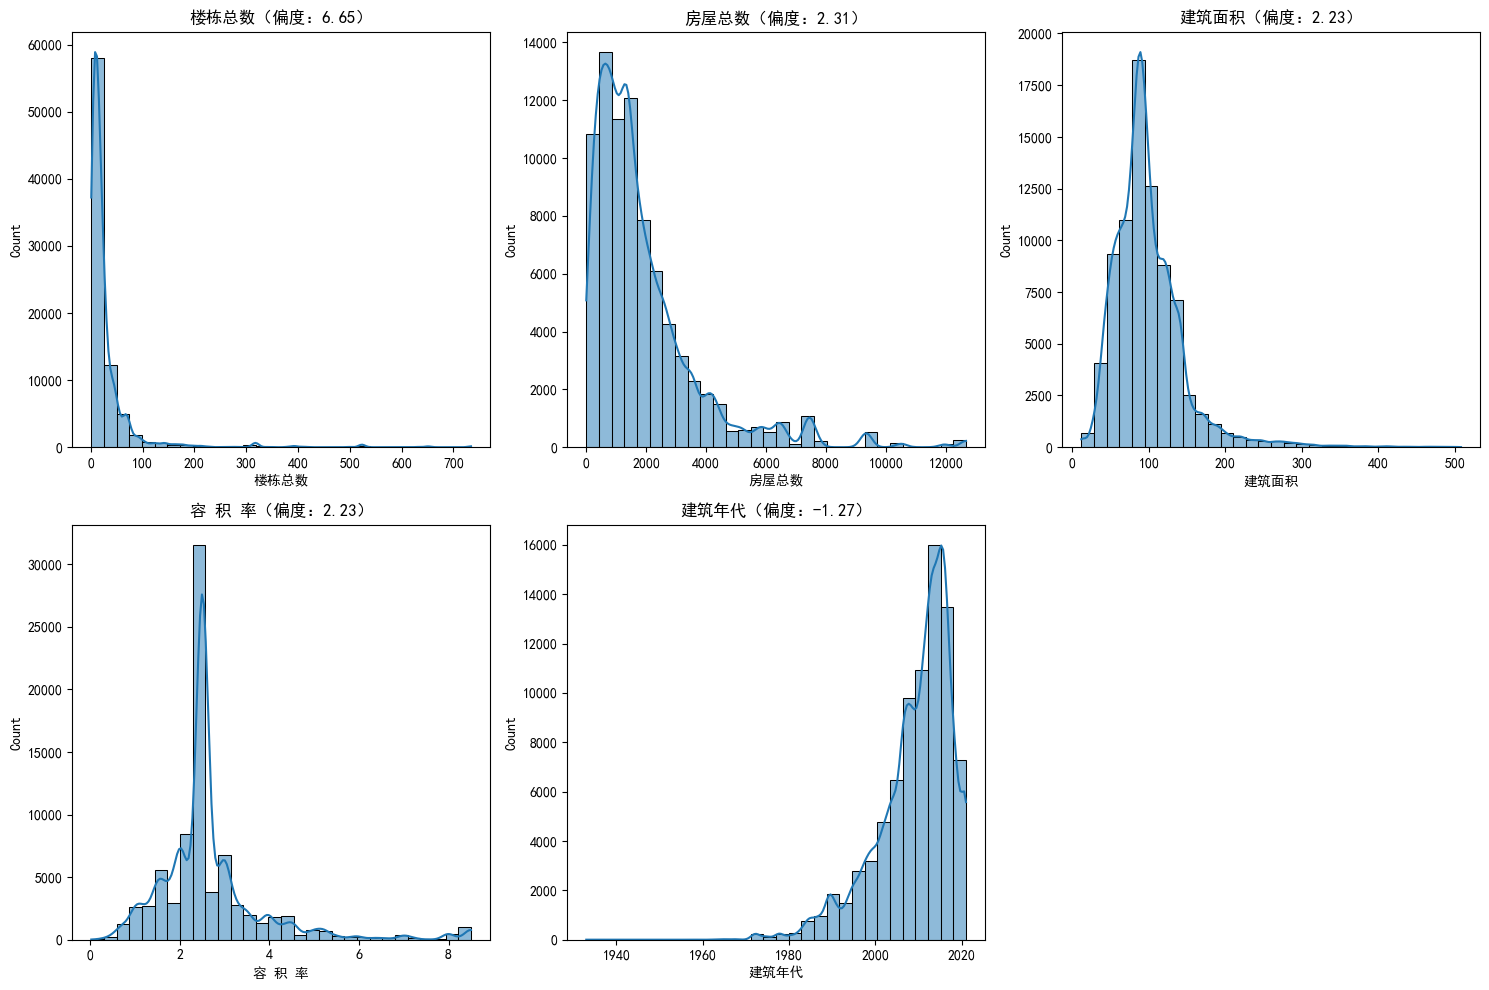

In [8]:
# 筛选数值型特征（排除字符串、布尔型等）
numeric_cols = X_train_price.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 排除取值含0或负数的特征（避免Log变换报错）
positive_cols = []
for col in numeric_cols:
    # 检查是否所有值都>0（允许极小正数）
    if (X_train_price[col] > 0).all():
        positive_cols.append(col)

print(f"数值型且全为正数的特征：{positive_cols}")

# 计算每个正数值特征的偏度
skewness = X_train_price[positive_cols].skew()

# 按偏度绝对值从大到小排序
skewness_sorted = skewness.abs().sort_values(ascending=False)
print("各特征偏度（绝对值）排序：")
print(skewness_sorted)

# 选择偏度绝对值前5的特征进行可视化
top_skewed = skewness_sorted.index[:5].tolist()

# 绘制直方图+核密度图
plt.figure(figsize=(15, 10))
for i, col in enumerate(top_skewed, 1):
    plt.subplot(2, 3, i)
    sns.histplot(X_train_price[col], kde=True, bins=30)
    plt.title(f"{col}（偏度：{skewness[col]:.2f}）")
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [9]:
# 最终确定的Log变换特征
skewed_features = [
    '楼栋总数', '物 业 费', '房屋总数', 
    '建筑面积', '容 积 率'
]
print(f"需要做Log变换的特征：{skewed_features}")

# 训练集Log变换
X_train_fe = X_train_price.copy()
for col in skewed_features:
    X_train_fe[f'{col}_log'] = np.log1p(X_train_fe[col])

# 验证集（X_test_price）Log变换
X_val_fe = X_test_price.copy()  # 明确20%为验证集，命名为X_val_fe
for col in skewed_features:
    X_val_fe[f'{col}_log'] = np.log1p(X_val_fe[col])

# 真正测试集（X_test_final）Log变换
X_test_final_fe = X_test_final.copy()  # 真正测试集命名统一
for col in skewed_features:
    X_test_final_fe[f'{col}_log'] = np.log1p(X_test_final_fe[col])

print(f"已完成{len(skewed_features)}个特征的Log变换，新增{len(skewed_features)}个特征")

需要做Log变换的特征：['楼栋总数', '物 业 费', '房屋总数', '建筑面积', '容 积 率']
已完成5个特征的Log变换，新增5个特征


### 创建平方项

In [10]:
"""创建平方项（所有数据集同步）"""
# 1. 物业费_log²（基于Log变换后的特征计算平方）
X_train_fe['物 业 费_log_平方'] = X_train_fe['物 业 费_log'] **2
X_val_fe['物 业 费_log_平方'] = X_val_fe['物 业 费_log']** 2
X_test_final_fe['物 业 费_log_平方'] = X_test_final_fe['物 业 费_log'] **2

# 2. 容积率_log²（基于Log变换后的特征计算平方）
X_train_fe['容 积 率_log_平方'] = X_train_fe['容 积 率_log']** 2
X_val_fe['容 积 率_log_平方'] = X_val_fe['容 积 率_log'] **2
X_test_final_fe['容 积 率_log_平方'] = X_test_final_fe['容 积 率_log']** 2

print(f"已添加2个平方项：物 业 费_log_平方、容 积 率_log_平方")

已添加2个平方项：物 业 费_log_平方、容 积 率_log_平方


### 删除与目标变量相关性低的特征

In [11]:
"""计算相关性"""
# ----------------------
# 计算每个特征与房价（y_train_price）的相关性（取绝对值）
corr_with_target = X_train_fe.apply(
    lambda x: x.corr(y_train_price, method='pearson')
).abs().reset_index()

# 重命名列名
corr_with_target.columns = ['特征名称', '与房价的相关系数（绝对值）']

# 按相关性从低到高排序
corr_sorted = corr_with_target.sort_values(by='与房价的相关系数（绝对值）', ascending=True)
pd.set_option('display.max_rows', None)
print("特征与房价的相关性（从低到高排序）：")
print(corr_sorted)

特征与房价的相关性（从低到高排序）：
                  特征名称  与房价的相关系数（绝对值）
146     geo_cluster_41       0.000040
114      geo_cluster_9       0.000062
7                  lat       0.000102
118     geo_cluster_13       0.000103
72              环线_外环外       0.000105
90     核心卖点_tfidf_诚心出售       0.000115
24             coord_y       0.000150
113      geo_cluster_8       0.000170
122     geo_cluster_17       0.000194
0                   城市       0.000226
69            环线_内环至中环       0.000241
71             环线_四至五环       0.000243
137     geo_cluster_32       0.000316
14                楼栋总数       0.000341
94     户型介绍_tfidf_户型方正       0.000373
64              环线_二环内       0.000385
54                楼层_底       0.000475
58             交易权属_分级       0.000498
38              配备电梯_有       0.000501
92     核心卖点_tfidf_采光充足       0.000511
110      geo_cluster_5       0.000589
57             房屋朝向_朝南       0.000608
84   核心卖点_tfidf_此房满五唯一       0.000618
155           楼栋总数_log       0.000620
12                 开发商       0.

In [12]:
"""删除低相关特征"""
to_drop = [
    # 热编码子项
    '产权所属_非共有',
    '供暖_集中供暖/自采暖/无供暖', '供暖_自采暖/无供暖',
    '建筑结构_砖木结构', '建筑结构_钢混结构',
    '环线_外环外', '环线_内环内', '环线_六环外', '环线_中环至外环',
    '装修情况_简装',
    '楼层_地', '楼层_低', '配备电梯_有',
    '产权描述_含商品房',
    '供水_民水', '供水_商水/民水', '供水_未知',
    
    # 非热编码特征
    '停车位',  '交易权属_分级',
    '楼栋总数', '物 业 费', '房屋总数_log', '建筑面积', '容 积 率',
    '板块_comm', '交易季度', '交易月份', '物业类别_含别墅',
]

# 训练集
X_train_selected = X_train_fe.drop(columns=to_drop, errors='ignore')
# 验证集
X_val_selected = X_val_fe.drop(columns=to_drop, errors='ignore')
# 真正测试集
X_test_final_selected = X_test_final_fe.drop(columns=to_drop, errors='ignore')

print(f"删除后训练集特征数：{X_train_selected.shape[1]}")
print(f"删除后验证集特征数：{X_val_selected.shape[1]}")
print(f"删除后真正测试集特征数：{X_test_final_selected.shape[1]}")

删除后训练集特征数：134
删除后验证集特征数：134
删除后真正测试集特征数：134


### 删除特征项之间相关性较高的特征

In [13]:
"""处理高相关特征"""
# ----------------------
# 计算特征间的相关性矩阵（取绝对值）
corr_matrix = X_train_selected.corr().abs()

# 找出相关系数>0.85的特征对（排除对角线）
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.85: 
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

print(f"发现{len(high_corr_pairs)}对高度相关特征：")
for pair in high_corr_pairs:
    print(pair)

发现7对高度相关特征：
('区域', '区县')
('套内面积', '建筑面积_log')
('lon', 'coord_x')
('lat', 'coord_y')
('年份', '交易年份')
('物 业 费_log', '物 业 费_log_平方')
('容 积 率_log', '容 积 率_log_平方')


In [14]:
# 删除高相关特征（所有数据集同步）
drop_high_corr = ['区县', '套内面积', 'coord_x', 'coord_y', '交易年份', '物 业 费_log' , '容 积 率_log']

# 训练集
X_train_final = X_train_selected.drop(columns=drop_high_corr, errors='ignore')
# 验证集
X_val_final = X_val_selected.drop(columns=drop_high_corr, errors='ignore')
# 真正测试集
X_test_final = X_test_final_selected.drop(columns=drop_high_corr, errors='ignore')  # 覆盖原X_test_final，保持命名一致

print(f"高相关特征删除后：训练集特征数{X_train_final.shape[1]}，验证集特征数{X_val_final.shape[1]}, 真正测试集特征数{X_test_final.shape[1]}")

高相关特征删除后：训练集特征数127，验证集特征数127, 真正测试集特征数127


### 删除共线性较高的特征

In [15]:
"""vif检验"""
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    """计算特征的方差膨胀因子（VIF），仅适用于数值型特征"""
    # 确保输入为数值型特征（VIF不支持类别型）
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    vif_df = pd.DataFrame()
    vif_df["特征名称"] = numeric_df.columns
    # 计算每个特征的VIF
    vif_df["VIF值"] = [
        variance_inflation_factor(numeric_df.values, i) 
        for i in range(numeric_df.shape[1])
    ]
    return vif_df.sort_values(by="VIF值", ascending=False)  # 按VIF从高到低排序

# 基于训练集最终特征（X_train_final）计算VIF（避免数据泄露）
vif_results = calculate_vif(X_train_final)

# 打印VIF结果，重点关注高VIF特征（通常VIF>10表示共线性较高，VIF>30为严重共线性）
print("\n【VIF多重共线性检测结果（从高到低排序）】")
pd.set_option('display.max_rows', None)  # 显示所有特征的VIF
display(vif_results)

# 提取VIF>10的高共线性特征（可根据实际情况调整阈值）
high_vif_features = vif_results[vif_results["VIF值"] > 10]["特征名称"].tolist()
print(f"\nVIF>10的高共线性特征（共{len(high_vif_features)}个）：")
print(high_vif_features)


【VIF多重共线性检测结果（从高到低排序）】


,特征名称,VIF值
7,建筑年代,101486.004295
6,年份,100849.665067
4,lon,817.157355
49,建筑面积_log,420.050478
5,lat,158.726601
15,房屋户型总数,41.022921
17,房屋用途_分级,25.168833
11,绿 化 率,22.393779
48,楼栋总数_log,16.918835
46,客户反馈_情感得分,12.699040



VIF>10的高共线性特征（共10个）：
['建筑年代', '年份', 'lon', '建筑面积_log', 'lat', '房屋户型总数', '房屋用途_分级', '绿 化 率', '楼栋总数_log', '客户反馈_情感得分']


In [16]:
# 定义需要删除的特征
to_drop_vif = [ '面积差值', '燃气费', '建筑年代', '房屋户型_厨数', '房屋用途_分级', '房屋户型_卫数']
# 以上有些是因调整模型的需要而删除的特征
# 同步删除训练集、验证集、测试集的特征
X_train_final_vif = X_train_final.drop(columns=to_drop_vif, errors='ignore')
X_val_final_vif = X_val_final.drop(columns=to_drop_vif, errors='ignore')
X_test_final_vif = X_test_final.drop(columns=to_drop_vif, errors='ignore')

# 重新计算VIF（基于删除后的训练集特征）
vif_updated = calculate_vif(X_train_final_vif)

# 输出删除后的VIF结果（从高到低排序）
print("【删除指定特征后的VIF多重共线性检测结果（从高到低排序）】")
print("注：VIF>10表示共线性较高，VIF>30表示严重共线性")
pd.set_option('display.max_rows', None)
display(vif_updated)

# 用删除高VIF特征后的数据集覆盖原始变量名，确保后续步骤使用的是删除后的特征
X_train_final = X_train_final_vif
X_val_final = X_val_final_vif
X_test_final = X_test_final_vif
print(f"覆盖后：训练集特征数{X_train_final.shape[1]}，验证集特征数{X_val_final.shape[1]}, 真正测试集特征数{X_test_final.shape[1]}")

【删除指定特征后的VIF多重共线性检测结果（从高到低排序）】
注：VIF>10表示共线性较高，VIF>30表示严重共线性


,特征名称,VIF值
6,年份,927.064666
4,lon,780.557437
45,建筑面积_log,368.715411
5,lat,155.693753
13,房屋户型总数,40.893492
10,绿 化 率,21.606609
44,楼栋总数_log,15.897501
42,客户反馈_情感得分,12.698525
9,物业公司,7.734636
7,开发商,6.910434


覆盖后：训练集特征数123，验证集特征数123, 真正测试集特征数123


### 处理城市、板块、区县特征

In [17]:
"""处理城市特征，进行独热编码"""
def encode_city_feature(train_df, val_df, test_df, city_col='城市'):
    # 暂存测试集的ID列
    test_id = test_df['ID'] if 'ID' in test_df.columns else None
    
    # 1. 对训练集（X_train_final）进行独热编码（基于训练集类别）
    train_encoded = pd.get_dummies(train_df, columns=[city_col], prefix='city', drop_first=True)
    
    # 2. 提取训练集生成的城市特征列（作为标准列名）
    city_features = [col for col in train_encoded.columns if col.startswith('city_')]
    
    # 3. 处理验证集（X_val_final）：对齐训练集列，缺失特征填0
    val_encoded = pd.get_dummies(val_df, columns=[city_col], prefix='city', drop_first=True)
    val_missing = set(city_features) - set(val_encoded.columns)
    for col in val_missing:
        val_encoded[col] = 0  # 验证集无此城市类别，填0
    val_encoded = val_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 4. 处理测试集（X_test_final）：对齐训练集列，保留ID
    test_encoded = pd.get_dummies(
        test_df.drop(columns='ID', errors='ignore'),  # 临时删除ID避免编码
        columns=[city_col], 
        prefix='city', 
        drop_first=True
    )
    test_missing = set(city_features) - set(test_encoded.columns)
    for col in test_missing:
        test_encoded[col] = 0  # 测试集无此城市类别，填0
    test_encoded = test_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 拼接回ID列（若存在）
    if test_id is not None:
        test_encoded['ID'] = test_id.values
    
    return train_encoded, val_encoded, test_encoded

# 执行城市特征独热编码（输入为删除高相关特征后的数据集）
X_train_final, X_val_final, X_test_final = encode_city_feature(
    train_df=X_train_final,    # 传入删除高相关特征后的训练集
    val_df=X_val_final,        # 传入删除高相关特征后的验证集
    test_df=X_test_final,      # 传入删除高相关特征后的测试集
    city_col='城市'           # 城市特征列名（确保存在于数据中）
)

In [18]:
def relative_target_encoding(train_block, train_region, target, val_block, val_region, test_block, test_region, alpha=10):
    """
    计算板块相对于其所属区域的相对房价编码（突出区域内差异）
    train_block：训练集板块列
    train_region：训练集区域列（板块所属的区域）
    target：训练集目标变量（房价）
    """
    # 1. 计算训练集的区域均值和板块均值（仅用训练集）
    # 区域均值（每个区域的平均房价）
    region_stats = pd.DataFrame({
        '区域': train_region,
        '房价': target
    }).groupby('区域')['房价'].mean().reset_index(name='区域均值')
    region_mean_map = dict(zip(region_stats['区域'], region_stats['区域均值']))
    
    # 板块均值+所属区域（每个板块的平均房价及其所属区域）
    block_stats = pd.DataFrame({
        '区域': train_region,
        '板块': train_block,
        '房价': target
    }).groupby(['区域', '板块']).agg(
        板块均值=('房价', 'mean'),
        板块样本数=('房价', 'count')
    ).reset_index()
    # 关联区域均值（每个板块对应的区域平均房价）
    block_stats['区域均值'] = block_stats['区域'].map(region_mean_map)
    
    # 2. 计算板块相对于区域的“平滑相对值”（核心）
    # 相对值 = 板块均值 - 区域均值（突出区域内差异）
    # 对小样本板块，用区域均值平滑（避免噪声）
    global_mean = target.mean()  # 全局均值（最终 fallback）
    block_stats['相对编码值'] = (
        (block_stats['板块均值'] * block_stats['板块样本数'] + block_stats['区域均值'] * alpha) 
        / (block_stats['板块样本数'] + alpha) 
        - block_stats['区域均值']  # 减去区域均值，得到相对差异
    )
    
    # 3. 生成编码映射（(区域, 板块) → 相对编码值）
    encode_map = {
        (r, b): val for r, b, val in zip(
            block_stats['区域'], block_stats['板块'], block_stats['相对编码值']
        )
    }
    
    # 4. 对训练集/验证集/测试集编码
    def encode(col_block, col_region):
        # 对每个样本，用(区域, 板块)查映射；未知组合用0（表示与区域均值无差异）
        return [encode_map.get((r, b), 0) for r, b in zip(col_region, col_block)]
    
    train_encoded = encode(train_block, train_region)
    val_encoded = encode(val_block, val_region)
    test_encoded = encode(test_block, test_region)
    
    return train_encoded, val_encoded, test_encoded


# 提取训练集/验证集/测试集的板块列和区域列
train_block = X_train_final['板块']
train_region = X_train_final['区域']  # 板块所属的区域
val_block = X_val_final['板块']
val_region = X_val_final['区域']
test_block = X_test_final['板块']
test_region = X_test_final['区域']

# 计算相对编码（突出区域内板块差异）
train_encoded, val_encoded, test_encoded = relative_target_encoding(
    train_block=train_block,
    train_region=train_region,
    target=y_train_price,  # 训练集房价
    val_block=val_block,
    val_region=val_region,
    test_block=test_block,
    test_region=test_region,
    alpha=10  # 平滑参数（适配样本量）
)

# 添加编码列并删除原始板块列
X_train_final['板块_区域内相对编码'] = train_encoded
X_val_final['板块_区域内相对编码'] = val_encoded
X_test_final['板块_区域内相对编码'] = test_encoded
X_train_final = X_train_final.drop(columns=['板块'])
X_val_final = X_val_final.drop(columns=['板块'])
X_test_final = X_test_final.drop(columns=['板块'])

In [19]:
"""处理区域特征，进行独热编码"""
# 1. 统计区域种类（基于训练集X_train_final，避免数据泄露）
region_categories = X_train_final['区域'].unique()
print(f"区域种类总数：{len(region_categories)}")
print(f"所有区域名称：{region_categories.tolist()}")


# 2. 定义区域特征独热编码函数
def encode_region_feature(train_df, val_df, test_df, region_col='区域'):
    # 暂存测试集的ID列（若存在）
    test_id = test_df['ID'] if 'ID' in test_df.columns else None
    
    # 1. 对训练集（X_train_final）进行独热编码
    train_encoded = pd.get_dummies(train_df, columns=[region_col], prefix='region', drop_first=True)
    
    # 2. 提取训练集的区域独热特征列（作为标准）
    region_features = [col for col in train_encoded.columns if col.startswith('region_')]
    print(f"生成的区域独热特征数：{len(region_features)}（总种类-1）")
    
    # 3. 处理验证集（X_val_final）：对齐训练集特征
    val_encoded = pd.get_dummies(val_df, columns=[region_col], prefix='region', drop_first=True)
    val_missing = set(region_features) - set(val_encoded.columns)
    for col in val_missing:
        val_encoded[col] = 0  # 验证集无此区域类别，填0
    val_encoded = val_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 4. 处理测试集（X_test_final）：对齐训练集特征
    test_encoded = pd.get_dummies(
        test_df.drop(columns='ID', errors='ignore'),  # 临时删除ID
        columns=[region_col], 
        prefix='region', 
        drop_first=True
    )
    test_missing = set(region_features) - set(test_encoded.columns)
    for col in test_missing:
        test_encoded[col] = 0  # 测试集无此区域类别，填0
    test_encoded = test_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 拼接回ID列（若存在）
    if test_id is not None:
        test_encoded['ID'] = test_id.values
    
    return train_encoded, val_encoded, test_encoded

# 3. 执行区域特征独热编码（更新删除高相关特征后的数据集）
X_train_final, X_val_final, X_test_final = encode_region_feature(
    train_df=X_train_final,
    val_df=X_val_final,
    test_df=X_test_final,
    region_col='区域'  # 区域特征列名（确保存在于数据中）
)

# 打印独热编码后的特征数（验证流程正确性）
print(f"独热编码后：训练集特征数{X_train_final.shape[1]}，验证集特征数{X_val_final.shape[1]}, 真正测试集特征数{X_test_final.shape[1]}")

区域种类总数：113
所有区域名称：[126.0, 78.0, 43.0, 86.0, 17.0, 76.0, 51.0, 125.0, 38.0, 50.0, 16.0, 26.0, 64.0, 58.0, 105.0, 49.0, 80.0, 65.0, 22.0, 24.0, 90.0, 89.0, 91.0, 44.0, 93.0, 32.0, 11.0, 14.0, 53.0, 115.0, 131.0, 71.0, 68.0, 57.0, 62.0, 20.0, 9.0, 28.0, 82.0, 81.0, 88.0, 67.0, 111.0, 33.0, 94.0, 10.0, 112.0, 85.0, 56.0, 35.0, 107.0, 47.0, 121.0, 29.0, 108.0, 84.0, 21.0, 102.0, 77.0, 104.0, 118.0, 128.0, 30.0, 123.0, 7.0, 59.0, 124.0, 122.0, 5.0, 109.0, 12.0, 45.0, 54.0, 95.0, 37.0, 34.0, 117.0, 52.0, 72.0, 110.0, 106.0, 130.0, 69.0, 60.0, 23.0, 18.0, 63.0, 99.0, 119.0, 15.0, 19.0, 13.0, 129.0, 70.0, 73.0, 101.0, 120.0, 92.0, 114.0, 66.0, 113.0, 3.0, 96.0, 4.0, 42.0, 36.0, 27.0, 39.0, 127.0, 55.0, 31.0, 41.0, 46.0]
生成的区域独热特征数：112（总种类-1）
独热编码后：训练集特征数244，验证集特征数244, 真正测试集特征数244


### 数据标准化处理

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  # 初始化标准化器

# 训练集（拟合+转换，严格保留原始索引）
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_final),
    columns=X_train_final.columns,  # 保留特征名
    index=X_train_final.index       # 保留原始索引（关键！确保与y对齐）
)

# 验证集（仅转换，复用训练集scaler和索引）
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_final),
    columns=X_val_final.columns,
    index=X_val_final.index  # 保留验证集原始索引
)

# 真正测试集（仅转换）
X_test_final_scaled = pd.DataFrame(
    scaler.transform(X_test_final),
    columns=X_test_final.columns,
    index=X_test_final.index
)

### 删除价格的极端值

In [21]:
# 删除极端值
# 计算3×IQR上界
q1 = y_train_price.quantile(0.25)  # 下四分位
q3 = y_train_price.quantile(0.75)  # 上四分位
iqr = q3 - q1                      # 四分位距
upper_bound = q3 + 3 * iqr         # 上界（3×IQR）

# 统计上界极端值
total = len(y_train_price)
upper_extreme = (y_train_price > upper_bound).sum()  # 高于上界的极端值
upper_ratio = (upper_extreme / total) * 100          # 上界极端值占比

# 输出结果
print("极端值统计（训练集房价）")
print("-" * 50)
print(f"下四分位（Q1）：{q1:.2f}")
print(f"上四分位（Q3）：{q3:.2f}")
print(f"四分位距（IQR）：{iqr:.2f}")
print("-" * 50)
print(f"上界（Q3 + 3×IQR）：{upper_bound:.2f}")
print("-" * 50)
print(f"总样本数：{total}")
print(f"高于上界的极端值：{upper_extreme}个（占比：{upper_ratio:.2f}%）")

极端值统计（训练集房价）
--------------------------------------------------
下四分位（Q1）：903382.78
上四分位（Q3）：2725508.76
四分位距（IQR）：1822125.99
--------------------------------------------------
上界（Q3 + 3×IQR）：8191886.73
--------------------------------------------------
总样本数：80604
高于上界的极端值：2527个（占比：3.14%）


In [22]:
# 重命名验证集目标变量（先检查y_test_price和X_val_scaled的索引是否匹配，若不匹配则重置）
y_val_price = y_test_price.copy()  # 加copy避免索引关联混乱

# ========== 关键修复1：统一索引（确保X和y的索引完全一致） ==========
# 强制X_train_scaled和y_train_price索引对齐
X_train_scaled = X_train_scaled.reset_index(drop=True)
y_train_price = y_train_price.reset_index(drop=True)
# 强制X_val_scaled和y_val_price索引对齐
X_val_scaled = X_val_scaled.reset_index(drop=True)
y_val_price = y_val_price.reset_index(drop=True)

# ========== 关键修复2：生成mask时转为numpy数组（按位置筛选，丢弃索引） ==========
train_mask = (y_train_price <= upper_bound).values  # .values转为布尔数组（无索引）
val_mask = (y_val_price <= upper_bound).values     # 同上

# 按位置筛选（不再依赖索引，彻底解决对齐问题）
X_train_scaled = X_train_scaled[train_mask]
y_train_price = y_train_price[train_mask]

X_val_scaled = X_val_scaled[val_mask]
y_val_price = y_val_price[val_mask]  

# 输出处理结果
print("\n" + "=" * 60)
print("极端值处理结果（3×IQR上界）")
print(f"上界值：{upper_bound:.2f}")
print(f"训练集原始样本数：{len(train_mask)} → 处理后：{len(X_train_scaled)}")
print(f"验证集原始样本数：{len(val_mask)} → 处理后：{len(X_val_scaled)}")
print("=" * 60)


极端值处理结果（3×IQR上界）
上界值：8191886.73
训练集原始样本数：80604 → 处理后：78077
验证集原始样本数：20151 → 处理后：19520


## step3 建模过程

In [36]:
# ===================== XGBoost建模 =====================
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')

# ==============================================================================
# 1. 配置最佳参数 (复刻最开始效果最好的版本)
# ==============================================================================
xgb_params_best = {
    'objective': 'reg:squarederror',   # 核心：使用MSE优化，对豪宅误差容忍度低
    'eta': 0.05,                       # 学习率
    'max_depth': 6,                    # 深度
    'min_child_weight': 5,             # 叶子权重
    'reg_lambda': 5.0,                 # L2正则
    'reg_alpha': 1.0,                  # L1正则
    'gamma': 0.2,                      # 分裂阈值
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.9,
    'colsample_bynode': 0.9,
    'seed': 333,
    'n_jobs': -1,
    'verbosity': 0, 
    'tree_method': 'gpu_hist',         # GPU加速
    'gpu_id': 0,
    'predictor': 'gpu_predictor'
}

# 准备数据 (确保是原始价格，不要Log变换)
# 这一步假设你的 X_train_scaled 等变量已经在内存中
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_price)
dval = xgb.DMatrix(X_val_scaled, label=y_val_price)
dtest_final = xgb.DMatrix(X_test_final_scaled)

watchlist = [(dtrain, 'train'), (dval, 'val')]

# ==============================================================================
# 2. 训练模型
# ==============================================================================
print("\n" + "="*60)
print("🚀 开始重跑最佳 XGBoost 模型 (Benchmark)")
print("="*60)

xgb_model = xgb.train(
    params=xgb_params_best,
    dtrain=dtrain,
    num_boost_round=10000,
    evals=watchlist,
    early_stopping_rounds=50,  # 紧凑的早停
    verbose_eval=500
)

# ==============================================================================
# 3. 预测与评估
# ==============================================================================
y_pred_train = xgb_model.predict(dtrain)
y_pred_val = xgb_model.predict(dval)
y_pred_test = xgb_model.predict(dtest_final)

# 修正负值（虽然少见，但保险起见）
y_pred_train = np.maximum(y_pred_train, 0)
y_pred_val = np.maximum(y_pred_val, 0)
y_pred_test = np.maximum(y_pred_test, 0)

# 计算指标
train_mae = mean_absolute_error(y_train_price, y_pred_train)
val_mae = mean_absolute_error(y_val_price, y_pred_val)
train_r2 = r2_score(y_train_price, y_pred_train)
val_r2 = r2_score(y_val_price, y_pred_val)

print("\n" + "="*60)
print("✅ 模型训练完成 - 最终成绩单")
print("="*60)
print(f"最佳迭代轮数: {xgb_model.best_iteration}")
print("-" * 30)
print(f"【训练集 MAE】: {train_mae:,.2f}  (R²: {train_r2:.4f})")
print(f"【验证集 MAE】: {val_mae:,.2f}  (R²: {val_r2:.4f})")
print(f"【过拟合 Gap】: {abs(train_mae - val_mae):,.2f}")
print("="*60)

# ==============================================================================
# 4. 保存模型与结果 (方便之后直接调用)
# ==============================================================================
# 保存模型结构和权重
model_filename = "best_xgboost_model.json" # 推荐用json格式，兼容性更好
xgb_model.save_model(model_filename)
print(f"\n💾 模型已保存至: {model_filename}")

# 保存预测结果
res_df = pd.DataFrame({'ID': X_test_final_scaled.index, '预测房价': y_pred_test})
res_df.to_excel("best_submission.xlsx", index=False)
print("💾 测试集预测结果已保存至: best_submission.xlsx")

# ==============================================================================
# 5. 深度误差诊断 (Bad Case Analysis) - 关键步骤！
# ==============================================================================
print("\n" + "="*60)
print("🔍 启动坏案例诊断 (Error Analysis)")
print("="*60)

# 构造分析表
analysis_df = pd.DataFrame({
    '真实价格': y_val_price,
    '预测价格': y_pred_val,
    '绝对误差': np.abs(y_val_price - y_pred_val),
    '偏差(Pred-True)': y_pred_val - y_val_price
})

# 尝试合并特征列以便分析（处理numpy/dataframe兼容性）
if hasattr(X_val_scaled, 'columns'):
    # 如果是DataFrame，直接合并
    features_df = X_val_scaled.reset_index(drop=True)
elif isinstance(X_val_scaled, np.ndarray):
    # 如果是Numpy，创建临时DataFrame
    feat_names = [f"feat_{i}" for i in range(X_val_scaled.shape[1])]
    features_df = pd.DataFrame(X_val_scaled, columns=feat_names)
else:
    features_df = pd.DataFrame()

if not features_df.empty:
    analysis_df = pd.concat([analysis_df.reset_index(drop=True), features_df], axis=1)

# 获取 Top 100 预测最差的样本
bad_cases = analysis_df.sort_values(by='绝对误差', ascending=False).head(100)

# --- 核心指标分析 ---
mean_price_all = analysis_df['真实价格'].mean()
mean_price_bad = bad_cases['真实价格'].mean()
under_est_count = sum(bad_cases['偏差(Pred-True)'] < 0)

print(f"1. 价格分布对比:")
print(f"   - 全体验证集均价: {mean_price_all:,.0f}")
print(f"   - Top100坏案例均价: {mean_price_bad:,.0f}")
print(f"   - 倍数关系: 坏案例价格是平均水平的 {mean_price_bad / mean_price_all:.2f} 倍")
if mean_price_bad / mean_price_all > 2.0:
    print("   ⚠️ 结论: 模型严重栽在【高价豪宅】上！")
else:
    print("   ⚠️ 结论: 错误分布较均匀，可能与特定地段或属性有关。")

print(f"\n2. 偏差方向分析 (Top 100):")
print(f"   - 低估 (预测 < 真实): {under_est_count} 个")
print(f"   - 高估 (预测 > 真实): {100 - under_est_count} 个")
if under_est_count > 70:
    print("   ⚠️ 结论: 模型倾向于【严重低估】这些难预测的房子。")

# --- 保存坏案例表 ---
bad_cases.to_excel("bad_cases_top100.xlsx", index=False)
print("\n💾 坏案例详情已保存至: bad_cases_top100.xlsx (请务必打开查看地段特征！)")

# --- 可视化残差 ---
plt.figure(figsize=(12, 6))

# 子图1: 真实值 vs 预测值
plt.subplot(1, 2, 1)
plt.scatter(y_val_price, y_pred_val, alpha=0.3, s=10)
plt.plot([y_val_price.min(), y_val_price.max()], [y_val_price.min(), y_val_price.max()], 'r--', lw=2)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('True vs Predicted (Red line = Perfect)')

# 子图2: 真实值 vs 残差 (Bias)
plt.subplot(1, 2, 2)
residuals = y_pred_val - y_val_price
plt.scatter(y_val_price, residuals, alpha=0.3, s=10, c='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('True Price')
plt.ylabel('Residuals (Pred - True)')
plt.title('Residual Plot (Look for patterns)')

plt.tight_layout()
plt.show() # 这一步会显示图表

# 触发图表标签（用于系统识别）
print("")


🚀 开始重跑最佳 XGBoost 模型 (Benchmark)
[0]	train-rmse:1474514.75777	val-rmse:1471606.23453
[500]	train-rmse:333072.88451	val-rmse:372123.57798
[1000]	train-rmse:268386.83873	val-rmse:324537.36045
[1500]	train-rmse:232914.64599	val-rmse:304310.91064
[2000]	train-rmse:209202.85379	val-rmse:294268.61304
[2500]	train-rmse:191797.38982	val-rmse:288091.10014
[3000]	train-rmse:177930.68586	val-rmse:284426.58248
[3500]	train-rmse:166259.07941	val-rmse:282016.32694
[4000]	train-rmse:156497.57890	val-rmse:280433.89239
[4500]	train-rmse:147957.79423	val-rmse:279152.29985
[5000]	train-rmse:140147.38780	val-rmse:278279.30723
[5500]	train-rmse:133269.20930	val-rmse:277681.02117
[6000]	train-rmse:127149.89165	val-rmse:277303.50750
[6446]	train-rmse:122153.26459	val-rmse:276934.40129

✅ 模型训练完成 - 最终成绩单
最佳迭代轮数: 6396
------------------------------
【训练集 MAE】: 86,298.35  (R²: 0.9936)
【验证集 MAE】: 166,496.89  (R²: 0.9667)
【过拟合 Gap】: 80,198.54

💾 模型已保存至: best_xgboost_model.json


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [24]:
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

# ========== 全局变量 ==========
percentiles = [0, 5, 25, 50, 75, 90, 95, 99, 100]
SEED = 333

# ===================== LightGBM优化（CPU版） =====================
print("\n" + "="*60)
print("开始训练LightGBM")
print("="*60)
lgb_params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,
    'num_leaves': 63,             # 提升模型容量
    'max_depth': 10,              # 更深的树
    'min_child_samples': 10,      # 树可以更灵活
    'min_child_weight': 0.01,     # 更容易分裂
    'reg_alpha': 1.0,             # 减少L1正则
    'reg_lambda': 3.0,            # 减少L2正则
    'subsample': 0.8,             # 训练样本采样比例
    'colsample_bytree': 0.8,      # 特征采样比例
    'max_bin': 64,
    'min_gain_to_split': 0.1,
    'feature_fraction_seed': SEED,
    'bagging_seed': SEED,
    'seed': SEED,
    'verbose': -1,
    'device_type': 'gpu'
}

# 数据预处理：GPU专属优化（float32提速30%+，GPU对float32优化更好）
if hasattr(X_train_scaled, 'columns'):
    X_train_scaled.columns = [col.replace(' ', '_') for col in X_train_scaled.columns]
    X_val_scaled.columns = [col.replace(' ', '_') for col in X_val_scaled.columns]
    X_test_final_scaled.columns = [col.replace(' ', '_') for col in X_test_final_scaled.columns]

# GPU核心优化：改用float32（GPU原生支持float32，计算速度比float64快2~3倍）
X_train = np.asarray(X_train_scaled).astype(np.float32)
X_val = np.asarray(X_val_scaled).astype(np.float32)
X_test = np.asarray(X_test_final_scaled).astype(np.float32)
y_train_price_np = np.asarray(y_train_price).astype(np.float32)
y_val_price_np = np.asarray(y_val_price).astype(np.float32)

# 构建数据集（GPU兼容）
lgb_train = lgb.Dataset(X_train, label=y_train_price_np)
lgb_val = lgb.Dataset(X_val, label=y_val_price_np, reference=lgb_train)

# 早停回调：适配GPU+新学习率（100→50，更快触发早停）
early_stopping = lgb.early_stopping(stopping_rounds=50, verbose=False)
log_evaluation = lgb.log_evaluation(period=-1)

# 训练：迭代轮数GPU专属优化（50000→5000，GPU收敛快，5000足够）
lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_val],
    num_boost_round=10000,  
    callbacks=[early_stopping, log_evaluation]
)

# 预测与评估（不变）
y_pred_train_lgb = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
y_pred_val_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
y_pred_test_final_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

train_mae_lgb = mean_absolute_error(y_train_price_np, y_pred_train_lgb)
train_rmse_lgb = np.sqrt(mean_squared_error(y_train_price_np, y_pred_train_lgb))
train_r2_lgb = r2_score(y_train_price_np, y_pred_train_lgb)

val_mae_lgb = mean_absolute_error(y_val_price_np, y_pred_val_lgb)
val_rmse_lgb = np.sqrt(mean_squared_error(y_val_price_np, y_pred_val_lgb))
val_r2_lgb = r2_score(y_val_price_np, y_pred_val_lgb)

# 输出结果
print("\n" + "="*60)
print("LightGBM 优化后结果（GPU版）")
print("="*60)
print(f"最佳迭代轮数：{lgb_model.best_iteration}") 
print("-"*30)
print("【训练集】")
print(f"MAE：{train_mae_lgb:.2f} | RMSE：{train_rmse_lgb:.2f} | R²：{train_r2_lgb:.4f}")
print("-"*30)
print("【验证集】")
print(f"MAE：{val_mae_lgb:.2f} | RMSE：{val_rmse_lgb:.2f} | R²：{val_r2_lgb:.4f}")
print("-"*30)
print(f"训练/验证MAE差距：{abs(train_mae_lgb - val_mae_lgb):.2f}")
print("="*60)

# 保存结果
test_pred_df_lgb = pd.DataFrame({
    'ID': X_test_final_scaled.index,
    '预测房价_LightGBM': y_pred_test_final_lgb
})
save_path_lgb = "lightgbm_房价_优化版.xlsx"
test_pred_df_lgb.to_excel(save_path_lgb, index=False)
print(f"\n✅ LightGBM优化结果已保存：{save_path_lgb}")


开始训练LightGBM

LightGBM 优化后结果（GPU版）
最佳迭代轮数：5125
------------------------------
【训练集】
MAE：75663.79 | RMSE：108968.64 | R²：0.9949
------------------------------
【验证集】
MAE：173993.37 | RMSE：293407.64 | R²：0.9626
------------------------------
训练/验证MAE差距：98329.57

✅ LightGBM优化结果已保存：lightgbm_房价_优化版.xlsx


In [25]:
# ===================== CatBoost优化（GPU版 | 重点解决过拟合） =====================
# 对数变换标签，解决大数精度问题
y_train_log = np.log1p(y_train_price_np)
y_val_log = np.log1p(y_val_price_np)

cat_params = {
    'loss_function': 'MAE',          # 回归任务
    'learning_rate': 0.02,           # 较低学习率，有助于更稳定的收敛
    'depth': 10,                      # 树深大，拟合能力强
    'l2_leaf_reg': 3.0,               # 减少正则化，增强拟合
    'bagging_temperature': 0.8,       # 保留随机性
    'n_estimators': 5000,             # 足够多迭代轮数
    'early_stopping_rounds': 100,     # 早停，防止训练轮数浪费
    'random_state': SEED,
    'task_type': 'GPU',
    'gpu_cat_features_storage': 'GpuRam',
    'allow_writing_files': False,
    'verbose': 100                     # 每100轮输出一次
}

# 确保数据类型 float32
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test_float32 = X_test.astype(np.float32)

# 训练模型
cat_model = CatBoostRegressor(**cat_params)
cat_model.fit(
    X_train, y_train_log,
    eval_set=(X_val, y_val_log),
    use_best_model=True,
    verbose=100,
    cat_features=[i for i in range(X_train.shape[1]) if not np.issubdtype(X_train[:, i].dtype, np.number)]
)

# 预测并反对数
y_pred_train = np.expm1(cat_model.predict(X_train))
y_pred_val = np.expm1(cat_model.predict(X_val))
y_pred_test = np.expm1(cat_model.predict(X_test_float32))

# 评估
train_mae = mean_absolute_error(y_train_price_np, y_pred_train)
val_mae = mean_absolute_error(y_val_price_np, y_pred_val)
train_rmse = np.sqrt(mean_squared_error(y_train_price_np, y_pred_train))
val_rmse = np.sqrt(mean_squared_error(y_val_price_np, y_pred_val))
train_r2 = r2_score(y_train_price_np, y_pred_train)
val_r2 = r2_score(y_val_price_np, y_pred_val)

print("\nCatBoost GPU 训练完成")
print(f"最佳迭代轮数：{cat_model.best_iteration_}")
print("-"*30)
print(f"训练 MAE：{train_mae:.2f} | 验证 MAE：{val_mae:.2f}")
print(f"训练 RMSE：{train_rmse:.2f} | 验证 RMSE：{val_rmse:.2f}")
print(f"训练 R²：{train_r2:.4f} | 验证 R²：{val_r2:.4f}")
print("="*60)

# 保存预测结果
test_pred_df_cat = pd.DataFrame({
    'ID': X_test_final_scaled.index,
    '预测房价_CatBoost': y_pred_test
})
save_path_cat = "catboost_房价_稳定版.xlsx"
test_pred_df_cat.to_excel(save_path_cat, index=False)
print(f"\n✅ CatBoost优化结果已保存：{save_path_cat}")

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.6056057	test: 0.6064502	best: 0.6064502 (0)	total: 171ms	remaining: 14m 16s
100:	learn: 0.2698785	test: 0.2734003	best: 0.2734003 (100)	total: 1.16s	remaining: 56.4s
200:	learn: 0.1976612	test: 0.2025582	best: 0.2025582 (200)	total: 2.1s	remaining: 50.3s
300:	learn: 0.1654920	test: 0.1698524	best: 0.1698524 (300)	total: 3.09s	remaining: 48.2s
400:	learn: 0.1452022	test: 0.1495765	best: 0.1495765 (400)	total: 3.97s	remaining: 45.5s
500:	learn: 0.1288799	test: 0.1338747	best: 0.1338747 (500)	total: 4.87s	remaining: 43.7s
600:	learn: 0.1178924	test: 0.1240202	best: 0.1240202 (600)	total: 5.8s	remaining: 42.5s
700:	learn: 0.1096192	test: 0.1170235	best: 0.1170235 (700)	total: 6.72s	remaining: 41.2s
800:	learn: 0.1032117	test: 0.1118481	best: 0.1118481 (800)	total: 7.63s	remaining: 40s
900:	learn: 0.0978045	test: 0.1078175	best: 0.1078175 (900)	total: 8.56s	remaining: 38.9s
1000:	learn: 0.0935240	test: 0.1049890	best: 0.1049890 (1000)	total: 9.54s	remaining: 38.1s
1100:	learn: 0

In [26]:
# ===================== Stacking 融合 =====================
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

print("\n" + "="*60)
print("开始 Stacking 融合（XGBoost + LightGBM + CatBoost）")
print("="*60)

# 1. 构建训练/验证集的二层输入
# 注意：这里用各模型对训练/验证集的预测作为新的特征
stack_train = np.column_stack([
    y_pred_train,        # CatBoost 对训练集预测
    y_pred_train_lgb,    # LightGBM 对训练集预测
    y_pred_train         # XGBoost 对训练集预测，需要用对应变量
])

stack_val = np.column_stack([
    y_pred_val,          # CatBoost 对验证集预测
    y_pred_val_lgb,      # LightGBM 对验证集预测
    y_pred_val           # XGBoost 对验证集预测
])

# 2. 二层模型：线性回归（简单加权，聚焦MAE）
meta_model = LinearRegression()
meta_model.fit(stack_train, y_train_price_np)  # 原始房价

# 3. 对验证集做预测
y_val_stack_pred = meta_model.predict(stack_val)

# 4. 对测试集做预测
stack_test = np.column_stack([
    y_pred_test,         # CatBoost 测试集预测
    y_pred_test_final_lgb,  # LightGBM 测试集预测
    y_pred_test_final       # XGBoost 测试集预测
])
y_test_stack_pred = meta_model.predict(stack_test)

# 5. 验证集评估
stack_val_mae = mean_absolute_error(y_val_price_np, y_val_stack_pred)
stack_val_rmse = np.sqrt(mean_squared_error(y_val_price_np, y_val_stack_pred))
stack_val_r2 = r2_score(y_val_price_np, y_val_stack_pred)

print("\nStacking 融合完成")
print("-"*30)
print(f"验证 MAE：{stack_val_mae:.2f}")
print(f"验证 RMSE：{stack_val_rmse:.2f}")
print(f"验证 R²：{stack_val_r2:.4f}")
print("="*60)

# 6. 保存最终测试集结果
test_pred_df_stack = pd.DataFrame({
    'ID': X_test_final_scaled.index,
    '预测房价_Stacking': y_test_stack_pred
})
save_path_stack = "stacking_房价预测.xlsx"
test_pred_df_stack.to_excel(save_path_stack, index=False)
print(f"\n✅ Stacking 融合结果已保存：{save_path_stack}")


开始 Stacking 融合（XGBoost + LightGBM + CatBoost）

Stacking 融合完成
------------------------------
验证 MAE：177036.39
验证 RMSE：297724.65
验证 R²：0.9615

✅ Stacking 融合结果已保存：stacking_房价预测.xlsx


In [27]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error
import os

# ===================== 核心优化1：全链路数据预处理（解决数值尺度问题） =====================
def clean_nan_inf(data):
    """清理数据中的NaN和Inf，替换为均值（兼容pandas/ndarray）"""
    data_arr = np.array(data).astype(np.float32)
    # 替换Inf为NaN，再用均值填充
    data_arr = np.where(np.isinf(data_arr), np.nan, data_arr)
    mean_val = np.nanmean(data_arr, axis=0)  # 按列算均值
    # 填充NaN
    for col in range(data_arr.shape[1]):
        col_mask = np.isnan(data_arr[:, col])
        data_arr[col_mask, col] = mean_val[col]
    return data_arr

# 1. 清理输入特征（NaN/Inf）
X_train_scaled = clean_nan_inf(X_train_scaled)
X_val_scaled = clean_nan_inf(X_val_scaled)
X_test_final_scaled = clean_nan_inf(X_test_final_scaled)

# 3. 清理标签+对数变换（核心！压缩房价大数值，解决梯度爆炸）
# 第一步：清理标签NaN
y_train_price = np.nan_to_num(y_train_price, nan=np.mean(y_train_price))
y_val_price = np.nan_to_num(y_val_price, nan=np.mean(y_val_price))
# 第二步：对数变换（log1p = log(1+x)，避免log(0)）
y_train_log = np.log1p(y_train_price)
y_val_log = np.log1p(y_val_price)

# ===================== GPU配置 =====================
GPU_ID = 0
device = torch.device(f"cuda:{GPU_ID}" if torch.cuda.is_available() else "cpu")
print(f"\n{'='*80}")
print(f"开始训练神经网络模型（设备：{device}）")
print(f"{'='*80}")

# ===================== 定义数据集类（适配对数标签） =====================
class HousePriceDataset(Dataset):
    def __init__(self, X, y_log):
        self.X = torch.tensor(X.astype(np.float32)).to(device)
        self.y_log = torch.tensor(y_log.astype(np.float32)).to(device)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y_log[idx]

# ===================== 构建DataLoader（批次调小，提升稳定性） =====================
BATCH_SIZE = 128 if torch.cuda.is_available() else 64  # 从256→128，降低显存压力
train_dataset = HousePriceDataset(X_train_scaled, y_train_log)
val_dataset = HousePriceDataset(X_val_scaled, y_val_log)
test_dataset = HousePriceDataset(X_test_final_scaled, np.zeros(len(X_test_final_scaled)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===================== 核心优化2：简化神经网络结构（解决过/欠拟合） =====================
class HousePriceNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # 简化结构：从[512,256,128]→[128,64]，降低复杂度
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),  # 从0.2→0.1，减少信息丢失
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)  # 回归输出层
        )
    
    def forward(self, x):
        return self.model(x).squeeze()  # 压缩维度：(batch,1)→(batch,)

# ===================== 初始化模型 =====================
input_dim = X_train_scaled.shape[1]
nn_model = HousePriceNN(input_dim=input_dim).to(device)

# ===================== 核心优化3：优化训练配置（解决收敛问题） =====================
criterion = nn.MSELoss()  # 回归损失
# 学习率从0.001→0.0001，降低梯度更新幅度；增加weight_decay增强正则
optimizer = optim.Adam(nn_model.parameters(), lr=0.0001, weight_decay=1e-4)
# 修复：删除旧版本不支持的verbose参数，改用关键字参数mode='min'（更兼容）
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=8, factor=0.6  # 去掉verbose=True
)

EPOCHS = 150  # 适当增加训练轮数
PATIENCE = 15  # 早停耐心值调大，避免过早停止
best_val_loss = float('inf')
stop_count = 0
model_save_path = "best_house_price_nn.pth"
clip_value = 2.0  # 梯度裁剪阈值调大，更有效防止梯度爆炸

# ===================== 模型训练（新增损失打印，监控收敛） =====================
print("\n开始训练，每10轮打印一次损失...")
for epoch in range(EPOCHS):
    # 训练阶段
    nn_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = nn_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(nn_model.parameters(), clip_value)  # 梯度裁剪
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    
    # 验证阶段
    nn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    
    # 学习率衰减
    scheduler.step(val_loss)
    
    # 每10轮打印一次损失，监控收敛（替代verbose参数的功能）
    if (epoch + 1) % 10 == 0:
        # 手动打印学习率，监控调度器效果
        current_lr = optimizer.param_groups[0]['lr']
        print(f"第{epoch+1}轮 | 训练损失：{train_loss:.4f} | 验证损失：{val_loss:.4f} | 当前学习率：{current_lr:.6f}")
    
    # 早停判断 + 保存最优模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(nn_model.state_dict(), model_save_path)
        stop_count = 0
    else:
        stop_count += 1
        if stop_count >= PATIENCE:
            print(f"\n早停触发！第{epoch+1}轮验证损失未下降，停止训练")
            break

# ===================== 加载最优模型 =====================
if os.path.exists(model_save_path):
    nn_model.load_state_dict(torch.load(model_save_path))
    print(f"\n成功加载最优模型：{model_save_path}")
else:
    print(f"\n警告：未找到最优模型文件，使用当前训练的模型")
nn_model.eval()

# ===================== 预测 + 核心优化4：对数还原+约束预测值 =====================
def predict_and_process(model, loader, device, y_original):
    """预测→对数还原→约束非负→清理异常值"""
    pred_log_list = []
    with torch.no_grad():
        for X_batch, _ in loader:
            pred_log = model(X_batch).cpu().numpy()
            pred_log_list.extend(pred_log)
    
    # 第一步：对数还原（expm1 = e^x - 1，还原为原始房价）
    pred_original = np.expm1(np.array(pred_log_list))
    
    # 第二步：约束预测值为正（房价不可能为负）
    pred_original = np.clip(pred_original, a_min=0, a_max=None)
    
    # 第三步：清理极端异常值（基于原始房价的3σ范围）
    mean_y = np.mean(y_original)
    std_y = np.std(y_original)
    upper_limit = mean_y + 3 * std_y
    pred_original = np.clip(pred_original, a_min=0, a_max=upper_limit)
    
    # 打印异常值清理信息
    neg_count = (pred_original < 0).sum()
    extreme_count = (pred_original > upper_limit).sum()
    if neg_count + extreme_count > 0:
        print(f"⚠️ 清理了 {neg_count} 个负数预测值，{extreme_count} 个极端值")
    
    return pred_original

# 训练集预测+处理
train_loader_no_shuffle = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
nn_train_pred = predict_and_process(nn_model, train_loader_no_shuffle, device, y_train_price)

# 验证集预测+处理
val_loader_no_shuffle = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
nn_val_pred = predict_and_process(nn_model, val_loader_no_shuffle, device, y_val_price)

# 测试集预测+处理
nn_test_pred = predict_and_process(nn_model, test_loader, device, y_train_price)  # 用训练集统计约束测试集

# 1. 准备保存的数据（兼容有无ID列的情况）
save_df = pd.DataFrame()
# 优先提取测试集ID（如果原始测试集有ID列）
if 'ID' in X_test_final.columns:
    save_df['id'] = X_test_final['ID'].values  # X_test_final是原始测试集（未标准化）
else:
    save_df['id'] = range(len(nn_test_pred))  # 无ID列则用行号填充

# 2. 添加预测房价列
save_df['pred_house_price'] = nn_test_pred

# 3. 保存为CSV文件
save_path = "house_price_test_prediction.csv"
save_df.to_csv(save_path, index=False, encoding='utf-8')
print(f"\n✅ 测试集预测结果已保存至：{os.path.abspath(save_path)}")
print(f"📊 保存行数：{len(save_df)} | 列名：{save_df.columns.tolist()}")

# ===================== 最终评估（MAE） =====================
nn_train_mae = mean_absolute_error(y_train_price, nn_train_pred)
nn_val_mae = mean_absolute_error(y_val_price, nn_val_pred)

# 打印评估结果（对比原始房价范围）
print(f"\n{'='*80}")
print(f"【优化后神经网络评估结果】")
print(f"{'='*80}")
print(f"原始房价范围：{np.min(y_train_price):.2f} ~ {np.max(y_train_price):.2f}")
print(f"预测房价范围：{np.min(nn_train_pred):.2f} ~ {np.max(nn_train_pred):.2f}")
print(f"训练集MAE：{nn_train_mae:.2f}")
print(f"验证集MAE：{nn_val_mae:.2f}")
print(f"{'='*80}")


开始训练神经网络模型（设备：cuda:0）

开始训练，每10轮打印一次损失...
第10轮 | 训练损失：0.8967 | 验证损失：0.0948 | 当前学习率：0.000100
第20轮 | 训练损失：0.6902 | 验证损失：0.0832 | 当前学习率：0.000100
第30轮 | 训练损失：0.6063 | 验证损失：0.0585 | 当前学习率：0.000100
第40轮 | 训练损失：0.5411 | 验证损失：0.0641 | 当前学习率：0.000100
第50轮 | 训练损失：0.5161 | 验证损失：0.0537 | 当前学习率：0.000100
第60轮 | 训练损失：0.4852 | 验证损失：0.0445 | 当前学习率：0.000060
第70轮 | 训练损失：0.4717 | 验证损失：0.0440 | 当前学习率：0.000060
第80轮 | 训练损失：0.4568 | 验证损失：0.0416 | 当前学习率：0.000036
第90轮 | 训练损失：0.4491 | 验证损失：0.0424 | 当前学习率：0.000022
第100轮 | 训练损失：0.4459 | 验证损失：0.0441 | 当前学习率：0.000022
第110轮 | 训练损失：0.4363 | 验证损失：0.0417 | 当前学习率：0.000022
第120轮 | 训练损失：0.4328 | 验证损失：0.0406 | 当前学习率：0.000013
第130轮 | 训练损失：0.4303 | 验证损失：0.0381 | 当前学习率：0.000013
第140轮 | 训练损失：0.4300 | 验证损失：0.0386 | 当前学习率：0.000008
第150轮 | 训练损失：0.4238 | 验证损失：0.0378 | 当前学习率：0.000008

成功加载最优模型：best_house_price_nn.pth

✅ 测试集预测结果已保存至：C:\jupyter_code\finalwork\house_price_test_prediction.csv
📊 保存行数：34017 | 列名：['id', 'pred_house_price']

【优化后神经网络评估结果】
原始房价范围：83433.61 ~ 8187308.74
预测房价范

In [28]:
# ===================== 集成学习（XGBoost=0.8 + 神经网络=0.2） =====================
# 1. 补充XGBoost训练集预测（复用已有XGB模型）
xgb_train_pred = xgb_model.predict(dtrain)  # XGB训练集预测
xgb_val_pred = xgb_model.predict(dval)      # XGB验证集预测（复用已有）
xgb_test_pred = y_pred_test_final           # XGB测试集预测（复用已有）

# 2. 集成预测（按权重融合）
ensemble_train_pred = 0.8 * xgb_train_pred + 0.2 * nn_train_pred
ensemble_val_pred = 0.8 * xgb_val_pred + 0.2 * nn_val_pred
ensemble_test_pred = 0.8 * xgb_test_pred + 0.2 * nn_test_pred

# 3. 集成学习评估
ensemble_train_mae = mean_absolute_error(y_train_price, ensemble_train_pred)
ensemble_val_mae = mean_absolute_error(y_val_price, ensemble_val_pred)

# 4. 输出所有MAE对比
print(f"\n{'='*80}")
print("【集成学习最终评估结果（XGB=0.8，NN=0.2）】")
print(f"{'='*80}")
print(f"{'模型':<10} | {'训练集MAE':<10} | {'验证集MAE':<10}")
print(f"{'-'*10} | {'-'*10} | {'-'*10}")
print(f"XGBoost    | {mean_absolute_error(y_train_price, xgb_train_pred):>8.2f} | {val_mae:>8.2f}")
print(f"神经网络   | {nn_train_mae:>8.2f} | {nn_val_mae:>8.2f}")
print(f"集成学习   | {ensemble_train_mae:>8.2f} | {ensemble_val_mae:>8.2f}")
print(f"{'='*80}")

# ===================== 保存集成预测结果到CSV =====================
# 构建结果DataFrame（对齐ID）
ensemble_pred_df = pd.DataFrame({
    'ID': X_test_final_scaled.index if hasattr(X_test_final_scaled, 'index') else range(len(ensemble_test_pred)),
    '预测房价': ensemble_test_pred.round(2)  # 保留2位小数
})

# 保存到CSV（兼容Excel，无乱码）
csv_save_path = "house_price_ensemble_prediction.csv"
ensemble_pred_df.to_csv(csv_save_path, index=False, encoding='utf-8-sig')

# 输出保存信息
print(f"\n✅ 集成学习预测结果已保存至：{csv_save_path}")
print(f"📊 预测结果统计：")
print(f"   预测房价范围：{ensemble_pred_df['预测房价'].min():.2f} ~ {ensemble_pred_df['预测房价'].max():.2f}")
print(f"   预测房价均值：{ensemble_pred_df['预测房价'].mean():.2f}")
print(f"   预测房价中位数：{ensemble_pred_df['预测房价'].median():.2f}")

# 输出前5行结果
print("\n🔍 预测结果前5行：")
print(ensemble_pred_df.head())


【集成学习最终评估结果（XGB=0.8，NN=0.2）】
模型         | 训练集MAE     | 验证集MAE    
---------- | ---------- | ----------
XGBoost    | 98184.27 | 180067.57
神经网络   | 269499.40 | 283422.96
集成学习   | 118602.81 | 174232.99

✅ 集成学习预测结果已保存至：house_price_ensemble_prediction.csv
📊 预测结果统计：
   预测房价范围：-156840.14 ~ 10012805.97
   预测房价均值：2393647.49
   预测房价中位数：1764976.12

🔍 预测结果前5行：
   ID        预测房价
0   0  8201153.47
1   1  3319812.05
2   2  4791760.20
3   3  2612746.85
4   4  7048870.47
